In [2]:
import graph_tool.all as gt
import logging
import pickle
import os


from evaluation.stats import eval_torch_batch, adjs_to_graphs, eval_graph_list, eval_acc_sbm_graph
from easydict import EasyDict as edict
import numpy as np
import torch

from evaluation.stats import eval_torch_batch, adjs_to_graphs, eval_graph_list
from utils.arg_helper import mkdir, set_seed, load_data, graphs_to_tensor, load_model, parse_arguments, \
    get_config
from utils.graph_utils import discretenoise, generate_mask, discretenoise_balanced_single, discretenoise_balanced, discretenoise_single_density, discretenoise_balanced_single_density
from utils.loading_utils import get_mc_sampler, eval_sample_batch, prepare_test_model_train
from utils.visual_utils import plot_graphs_list, plot_inter_graphs, plot_inter_graphs_list, plot_inter_graphs_j

from easydict import EasyDict as edict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from evaluation.stats import eval_torch_batch

from model.langevin_mc import LangevinMCSampler

from utils.arg_helper import edict2dict, parse_arguments, get_config, process_config, set_seed_and_logger, load_data
from utils.graph_utils import gen_list_of_data_single, generate_mask
from utils.loading_utils import get_mc_sampler, get_score_model, eval_sample_batch
from utils.visual_utils import plot_graphs_adj
from model.ppgn import Powerful
from matplotlib import pyplot as plt
import wandb

In [3]:
import time

In [4]:
import sys
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
sysout=sys.stdout
# Restore
def enablePrint():
    sys.stdout = sysout

def sample_main(config,modellink,epoch,noise_num):
    
    print(config.dev)
    print(3)
    device=sys.stdout
    blockPrint()
    #config = edict(ori_config.copy())
    #config.save_dir = os.path.join(config.save_dir, 'sample')
    #mkdir(config.save_dir)
    #config.model_files = []
    #config.init_sigma = 'inf'
    #set_seed(config, args)
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    #models = prepare_test_model(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = config.test.batch_size
    test_batch_size = 1
    #log_inter_steps = config.inter_log.log_inter_steps
    #steps_to_log = config.inter_log.steps_to_log
    print(config.dev)
    print(3)
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        print("wwwwww")
        
        return initialmatrix, base_x, node_flags
        ##returns initialmatrix = tensor of size batchsize x N x N


    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    ##model.eval()

    def add_bernoulli(flags, init_adjs, noiselevel):
        init_adjs, noise_added = discretenoise(init_adjs, flags, noiselevel, config)
        return init_adjs


    def take_step(noise_func, flags, init_adjs, noiselevel):
        init_adjs = add_bernoulli(flags, init_adjs, noiselevel)
        
        mask=generate_mask(flags).to(config.dev)
        
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+noise_rel.transpose(-1,-2))/2
        
        enablePrint()
        #print(noise_rel)
        blockPrint()
        noise=torch.bernoulli(noise_rel)*mask
        #noise = torch.where(noise_rel<0.5, torch.zeros_like(noise_rel), torch.ones_like(noise_rel))
        
        inter_adjs = torch.where(noise>1/2,init_adjs-1,init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2 , inter_adjs+2 , inter_adjs)
        
        return init_adjs,new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs, init_x, flags = gen_init_data(batch_size = test_batch_size)

                #########3
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ########3


                ####check if border correct
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    enablePrint()
                    print(init_adjs.get_device())
                    blockPrint()
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)


        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        #logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        return result_dict, gen_graph_list

    result_dict, gen_graph_list = run_sample(eval_len=32)
    #sample_dir = os.path.join(config.save_dir, 'sample_data')
    #if not os.path.exists(sample_dir):
    #    os.makedirs(sample_dir)
    ##changed path here since bestconfig doesnt exist
    #with open(os.path.join(sample_dir, file + "_sample.pkl"), 'wb') as f:
    #    pickle.dump(obj=gen_graph_list, file=f, protocol=pickle.HIGHEST_PROTOCOL)
    return result_dict

def sample_main_noise2(config,modellink,epoch,noise_num):
    
    print(config.dev)
    print(3)
    device=sys.stdout
    blockPrint()
    #config = edict(ori_config.copy())
    #config.save_dir = os.path.join(config.save_dir, 'sample')
    #mkdir(config.save_dir)
    #config.model_files = []
    #config.init_sigma = 'inf'
    #set_seed(config, args)
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    #models = prepare_test_model(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    #test_batch_size = config.test.batch_size
    test_batch_size = 1
    #log_inter_steps = config.inter_log.log_inter_steps
    #steps_to_log = config.inter_log.steps_to_log
    print(config.dev)
    print(3)
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        print("wwwwww")
        
        return initialmatrix, base_x, node_flags
        ##returns initialmatrix = tensor of size batchsize x N x N


    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1,noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    ##model.eval()

    def add_bernoulli(flags, init_adjs, noiselevel):
        init_adjs, noise_added = discretenoise(init_adjs, flags, noiselevel, config)
        return init_adjs


    def take_step(noise_func, flags, init_adjs, noiselevel):
        init_adjs = add_bernoulli(flags, init_adjs, noiselevel)
        
        mask=generate_mask(flags).to(config.dev)
        
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise = torch.where(noise_rel<0.5, torch.zeros_like(noise_rel), torch.ones_like(noise_rel))
        
        inter_adjs = torch.where(noise>1/2,init_adjs-1,init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2 , inter_adjs+2 , inter_adjs)
        
        return init_adjs,new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs, init_x, flags = gen_init_data(batch_size = test_batch_size)

                #########3
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ########3


                ####check if border correct
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    enablePrint()
                    print(init_adjs.get_device())
                    blockPrint()
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)


        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        #logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        return result_dict, gen_graph_list

    result_dict, gen_graph_list = run_sample(eval_len=1)
    #sample_dir = os.path.join(config.save_dir, 'sample_data')
    #if not os.path.exists(sample_dir):
    #    os.makedirs(sample_dir)
    ##changed path here since bestconfig doesnt exist
    #with open(os.path.join(sample_dir, file + "_sample.pkl"), 'wb') as f:
    #    pickle.dump(obj=gen_graph_list, file=f, protocol=pickle.HIGHEST_PROTOCOL)
    return result_dict







In [5]:
def plot_inter_graphs_jup(graphs,flags,title,save_dir,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    print(pos)
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        #print("w")
        #print(len(sigmalevel_adjs))
        #print("w")
        nodes=flags.sum(-1)
        #print(nodes)
        #print(i)
        """
        if i==0:
            nrofnodes=nodes[nr_to_analyze]
        else:"""
        #nrofnodes=nodes[(i)*32+nr_to_analyze]

        
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        print(G.nodes)
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
            # print(nx.get_node_attributes(G, 'feature'))
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)


options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}


from argparse import Namespace
import networkx as nx
args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_5.5_1:46/gridsearch_ppgn_consec_sbm_27_200_6,32_7_32.yaml', log_level='INFO', comment='')
ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)
#print(config_dict)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-05-01-52-52_9718/models",1,8)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-05-01-52-52_6702/models",1,100)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-08-14-50-33_10454/models",1,16)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-08-19-38-45_12711/models",1,16)

sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-10-14-22-20_12504/models",1,16)



def discretenoise_balanced(train_adj_b,node_flags,sigma):
    train_adj_b = train_adj_b
    ##if Aij=1 then chances for being 1 later is 1-sigma so chance of changing is sigma
    sigma=sigma*2
    print(torch.full_like(train_adj_b,sigma))
    noise_upper=torch.bernoulli(torch.full_like(train_adj_b,sigma)).triu(diagonal=1)
    noise_lower = noise_upper.transpose(-1, -2)
    noise = noise_upper + noise_lower
    sampled = torch.bernoulli(torch.where(noise>1/2,1/2,0.0))
    noisediff = torch.zeros_like(train_adj_b)
    for i,adj in enumerate(noise):
        for j,vec in enumerate(adj):
            for k,node  in enumerate(vec):
                if node>0.9:
                    if train_adj_b[i][j][k]>sampled[i][j][k]:
                        noisediff[i][j][k] =  1.0
                    elif train_adj_b[i][j][k] < sampled[i][j][k]:
                        noisediff[i][j][k] = 1.0

                    train_adj_b[i][j][k]=sampled[i][j][k]
                    
    return train_adj_b, noisediff


adjtest=torch.tensor([[[1.0,1.0],[1.0,1.0]]])
flagstest=torch.tensor([[1,1]])
discretenoise_balanced(adjtest,flagstest,0.5)

def discretenoise_balanced_single(train_adj_b,node_flags,sigma):
    train_adj_b = train_adj_b
    print("balance")
    ##if Aij=1 then chances for being 1 later is 1-sigma so chance of changing is sigma
    sigmalocl=sigma*2
    noise_upper=torch.bernoulli(torch.full_like(train_adj_b,sigma)).triu(diagonal=1)
    noise_lower = noise_upper.transpose(-1, -2)
    print(noise_lower)
    
    noise = noise_upper + noise_lower
    print(noise)
    sampled_lower = torch.bernoulli(torch.where(noise>1/2,1/2,0.0)).triu(diagonal=1)
    sampled=sampled_lower+sampled_lower.transpose(-1, -2)
    
    noisediff = torch.zeros_like(train_adj_b)
   
    for j,vec in enumerate(noise):
        for k,node  in enumerate(vec):
            if node>0.9:
                if train_adj_b[j][k]>sampled[j][k]:
                    noisediff[j][k] =  1.0
                elif train_adj_b[j][k] < sampled[j][k]:
                    noisediff[j][k] = 1.0
                train_adj_b[j][k]=sampled[j][k]
    train_adj_b=mask_adjs(train_adj_b, node_flags)
    noisediff = mask_adjs(noisediff, node_flags)
    return train_adj_b, noisediff       


def mask_adjs(adjs, node_flags):
    """

    :param adjs:  B x N x N or B x C x N x N
    :param node_flags: B x N
    :return:
    """
    # assert node_flags.sum(-1).gt(2-1e-5).all(), f"{node_flags.sum(-1).cpu().numpy()}, {adjs.cpu().numpy()}"
    if len(adjs.shape) == 4:
        node_flags = node_flags.unsqueeze(1)  # B x 1 x N
    adjs = adjs * node_flags.unsqueeze(-1)
    adjs = adjs * node_flags.unsqueeze(-2)
    return adjs

adjtest=torch.tensor([[2.0,1.0,1.0,1.0],[1.0,2.0,1.0,1.0],[1.0,1.0,2.0,1.0],[1.0,1.0,1.0,2.0]])
flagstest=torch.tensor([0,1,1,0])
discretenoise_balanced_single(adjtest,flagstest,0.5)


print(sys.__stdout__)


from argparse import Namespace
import networkx as nx
args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_5.5_1:46/gridsearch_ppgn_consec_trees_60_200_pkl_6,32_7_32.yaml', log_level='INFO', comment='')
ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)
#print(config_dict)
sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-08-14-53-38_6269/models",1,16)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-05-01-52-52_6702/models",1,16)

In [6]:
def sample_main_density(config,modellink,epoch,noise_num):
    print(config.dev)
    device=sys.stdout
    blockPrint()
    #config = edict(ori_config.copy())
    #config.save_dir = os.path.join(config.save_dir, 'sample')
    #mkdir(config.save_dir)
    #config.model_files = []
    #config.init_sigma = 'inf'
    #set_seed(config, args)
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    #models = prepare_test_model(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = 1
    #log_inter_steps = config.inter_log.log_inter_steps
    #steps_to_log = config.inter_log.steps_to_log
    print(config.dev)
    enablePrint()
    
    
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)
        #node_flags=torch.ones_like(node_flags)
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        edgetens = torch.zeros(base_adjs.size(0))
        for i,adj in enumerate(base_adjs):
            edgetens[i] = adj.sum()/node_flags[i].sum()
        """
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        print("wwwwww")"""
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        
        for i,k in enumerate(base_adjs):
            enablePrint()
            print("dense1")
            abc = [0,1,0]
            n = node_flags[i].sum()
            #print(edgetens[i])
            print("nn")
            print(n)
            density = edgetens[i]
            
            #print(density)
            bernoulli_adj[i], _ = discretenoise_single_density(bernoulli_adj[i], node_flags[i], 0.5, abc, density, config)
            print("mm")
            print(bernoulli_adj[i].sum())
        initialmatrix = bernoulli_adj
        print("finit")
        blockPrint()     
        return initialmatrix, base_x, node_flags, edgetens
        ##returns initialmatrix = tensor of size batchsize x N x N

    enablePrint()
    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    ##model.eval()

    def add_bernoulli(flags, init_adjs, noiselevel,edgetens):
        enablePrint()
        
        init_adjs_like= torch.zeros_like(init_adjs)
        noise_added_like = torch.zeros_like(init_adjs)
        
        for i,k in enumerate(init_adjs):
            print("dense")
            abc = [0,1,0]
            n = flags[i].sum()
            density = edgetens[i]
            print("density")
            print(density)
            
            #print(density)
            init_adjs_like[i], noise_added_like[i] = discretenoise_single_density(init_adjs[i], flags[i], noiselevel,abc ,density , config)
            print("nnnn:")
            print(flags[i].sum())
            print("mmmm:")
            print(init_adjs_like[i].sum())
            blockPrint()     
        return init_adjs_like


    def take_step(noise_func, flags, init_adjs, noiselevel, edgetens):
        init_adjs = add_bernoulli(flags, init_adjs, noiselevel, edgetens)
        
        mask=generate_mask(flags).to(config.dev)
        
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise = torch.where(noise_rel<0.5, torch.zeros_like(noise_rel), torch.ones_like(noise_rel))
        
        inter_adjs = torch.where(noise > 1/2,init_adjs - 1,init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2 , inter_adjs + 2 , inter_adjs)
        
        return init_adjs,new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                enablePrint()
                print("W")
                blockPrint()
                count=0
                init_adjs, init_x, flags, edgetens = gen_init_data(batch_size = test_batch_size)

                #########3
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ########3


                ####check if border correct
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel,edgetens=edgetens)
                    count=count+1
                    enablePrint()
                    print(init_adjs.get_device())
                    blockPrint()
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)


        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        print(result_dict)
        logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        return result_dict, gen_graph_list

    result_dict, gen_graph_list = run_sample(eval_len=32)
    #sample_dir = os.path.join(config.save_dir, 'sample_data')
    #if not os.path.exists(sample_dir):
    #    os.makedirs(sample_dir)
    ##changed path here since bestconfig doesnt exist
    #with open(os.path.join(sample_dir, file + "_sample.pkl"), 'wb') as f:
    #    pickle.dump(obj=gen_graph_list, file=f, protocol=pickle.HIGHEST_PROTOCOL)
    return result_dict

In [9]:

def sample_main_bala(config,modellink,epoch,noise_num):
    print(config.dev)
    device=sys.stdout
    blockPrint()
    #config = edict(ori_config.copy())
    #config.save_dir = os.path.join(config.save_dir, 'sample')
    #mkdir(config.save_dir)
    #config.model_files = []
    #config.init_sigma = 'inf'
    #set_seed(config, args)
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    #models = prepare_test_model(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = 1
    #log_inter_steps = config.inter_log.log_inter_steps
    #steps_to_log = config.inter_log.steps_to_log
    print(config.dev)
    enablePrint()
    
    
    def gen_init_data(batch_size):
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)
        #node_flags=torch.ones_like(node_flags)
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        edgetens = torch.zeros(base_adjs.size(0))
        enablePrint()
        for i,adj in enumerate(base_adjs):
            edgetens[i] = adj.sum()/node_flags[i].sum()
            print(edgetens[i])
            print(99999)
        """
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        print("wwwwww")"""
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        
        for i,k in enumerate(base_adjs):
            
            print("dense1")
            abc = [0,1,0]
            n = node_flags[i].sum()
            #print(edgetens[i])
            print("nn")
            print(n)
            density = edgetens[i]
            
            #print(density)
            bernoulli_adj[i], _ = discretenoise_balanced_single_density(bernoulli_adj[i], node_flags[i], 0.5, abc, density, config)
            print("mm")
            print(bernoulli_adj[i].sum())
        initialmatrix = bernoulli_adj
        print("finit")
        blockPrint()     
        return initialmatrix, base_x, node_flags, edgetens
        ##returns initialmatrix = tensor of size batchsize x N x N

    enablePrint()
    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    ##model.eval()

    def add_bernoulli(flags, init_adjs, noiselevel,edgetens):
        enablePrint()
        
        init_adjs_like= torch.zeros_like(init_adjs)
        noise_added_like = torch.zeros_like(init_adjs)
        
        for i,k in enumerate(init_adjs):
            print("dense")
            abc = [0,1,0]
            n = flags[i].sum()
            density = edgetens[i]
            print("density")
            print(density)
            
            #print(density)
            init_adjs_like[i], noise_added_like[i] = discretenoise_balanced_single_density(init_adjs[i], flags[i], noiselevel,abc ,density , config)
            print("nnnn:")
            print(flags[i].sum())
            print("mmmm:")
            print(init_adjs_like[i].sum())
            blockPrint()     
        return init_adjs_like


    def take_step(noise_func, flags, init_adjs, noiselevel, edgetens):
        init_adjs = add_bernoulli(flags, init_adjs, noiselevel, edgetens)
        
        mask=generate_mask(flags).to(config.dev)
        
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1,-2))/2
        
        
        
        
        
        noise = torch.where(noise_rel<0.5, torch.zeros_like(noise_rel), torch.ones_like(noise_rel))
        
        inter_adjs = torch.where(noise > 1/2,init_adjs - 1,init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2 , inter_adjs + 2 , inter_adjs)
        
        return init_adjs,new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                enablePrint()
                print("W")
                blockPrint()
                count=0
                init_adjs, init_x, flags, edgetens = gen_init_data(batch_size = test_batch_size)

                #########3
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ########3


                ####check if border correct
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel,edgetens=edgetens)
                    count=count+1
                    enablePrint()
                    print(init_adjs.get_device())
                    blockPrint()
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        #plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        


        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        print(result_dict)
        logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        return result_dict, gen_graph_list

    result_dict, gen_graph_list = run_sample(eval_len=1)
    #sample_dir = os.path.join(config.save_dir, 'sample_data')
    #if not os.path.exists(sample_dir):
    #    os.makedirs(sample_dir)
    ##changed path here since bestconfig doesnt exist
    #with open(os.path.join(sample_dir, file + "_sample.pkl"), 'wb') as f:
    #    pickle.dump(obj=gen_graph_list, file=f, protocol=pickle.HIGHEST_PROTOCOL)
    return result_dict

In [10]:
def posterior(sigmatilde_t,sigma_t,sigmatilde_t1,x0,xt):
    if xt<0.01 and x0<0.01:
        return sigmatilde_t1 * sigma_t / (1-sigmatilde_t)
    elif xt>0.99 and x0<0.01:
        return sigmatilde_t1 * (1-sigma_t) / (sigmatilde_t)
    elif xt>0.99 and x0>0.99:
        return (1-sigmatilde_t1) * (1-sigma_t) / (1-sigmatilde_t)
    if xt<0.01 and x0>0.99:
        return (1-sigmatilde_t1) * sigma_t / (sigmatilde_t)



def sigma_lin_false(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if i<0.0000000001:
            sigmas.append(0.0)
        summ=0.0
        for k,sigpast in enumerate(sigmas):
            prod=1.0
            for j in range(0,g-1-k):
                prod = prod * ( 1 - 2 * sigmas[g-k] )
            prod = prod * sigmas[k]
        summ+=prod
        s=sigma-summ
        sigmas.append(s)

def sigma_lin(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if sigma<0.0000000001:
            sigmas.append(0.0)
            continue
        sigmas.append(((1-sigma)-(1-sigma_list[g-1]))/(1-2*(1-sigma_list[g-1])))
    return sigmas

def sample_main_new(config,modellink,epoch,noise_num):
    start_time = time.time()
    print(config.dev)
    print(3)
    device=sys.stdout
    blockPrint()
    #config = edict(ori_config.copy())
    #config.save_dir = os.path.join(config.save_dir, 'sample')
    #mkdir(config.save_dir)
    #config.model_files = []
    #config.init_sigma = 'inf'
    #set_seed(config, args)
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    #models = prepare_test_model(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = config.test.batch_size
    test_batch_size = 1
    #log_inter_steps = config.inter_log.log_inter_steps
    #steps_to_log = config.inter_log.steps_to_log
    print(config.dev)
    print(3)
    def gen_init_data(batch_size):
        
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        print("wwwwww")
        
        
        return initialmatrix, base_x, node_flags
        ##returns initialmatrix = tensor of size batchsize x N x N


    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,noise_num+1)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    ##model.eval()
    sigma_list_nontilde=sigma_lin(sigma_list)

    def add_bernoulli(flags, init_adjs, noiselevel):
        init_adjs, noise_added = discretenoise(init_adjs, flags, noiselevel, config)
        return init_adjs


    def take_step(noise_func, flags, init_adjs, noiselevel,noiselevel_nontilde):
        
        
        
        mask=generate_mask(flags).to(config.dev)
        init_adjs = init_adjs * mask
        noise_unnormal = noise_func(A=init_adjs.to(config.dev),feat=None,mask=mask.to(config.dev),noise=noiselevel).to(config.dev)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here now noise_rel = p(xo_switched | xt)
        
        """
        for i,adj in enumerate(init_adjs):
            sigmatilde_t=noiselevel
            sigma_t=noiselevel_nontilde
            sigmatilde_t1=sigmatilde_t-sigmatilde_t/sigma_list.index(sigmatilde_t)
            enablePrint()
            print(sigmatilde_t)
            print(sigma_t)
            print(sigmatilde_t1)
            print("finit")
            blockPrint()
            
            ##if the xt=1 then pswitched = px0=0, xt is initadjs
            score_i=torch.where(init_adjs[i]>1/2,1-noise_rel[i],noise_rel[i])
            
            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.zeros_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.zeros_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p = ( 1 - score_i ) * mult1*mult2/div

            ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.ones_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.ones_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p += ( score_i ) * mult1 * mult2/div
            init_adjs[i]=p"""
        
        
        sigmatilde_t=noiselevel
        sigma_t=noiselevel_nontilde
        sigmatilde_t1=sigmatilde_t-sigmatilde_t/sigma_list.index(sigmatilde_t)
        
        score_i=torch.where(init_adjs>1/2,1-noise_rel,noise_rel)
        
        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,0,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.zeros_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.zeros_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p = ( 1 - score_i ) * mult1*mult2/div

        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.ones_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.ones_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p += ( score_i ) * mult1 * mult2/div

        ##p stands now for probablity p(x0=1|xt=xt)
        init_adjs = (p + p.transpose(-2,-1))/2
            
            
        
        """
        
        for i,adj in enumerate(init_adjs):
            for j,row in enumerate(adj):
                for k, el in enumerate(row):
                    xt=el
                    sigmatilde_t=noiselevel
                    sigma_t=noiselevel_nontilde
                    enablePrint()
                    #print(sigma_list)
                    blockPrint()
                    sigma_t1=sigmatilde_t-sigmatilde_t/sigma_list.index(sigmatilde_t)
                    p=0.0
                    ##if original is 0 then score is prob
                    if init_adjs[i][j][k]<0.01:
                        noise_rel[i][j][k] = torch.sigmoid(noise_rel[i][j][k])
                    ##if original is 1 then 1-score is prob
                    elif init_adjs[i][j][k]>0.99:
                        noise_rel[i][j][k] = 1-torch.sigmoid(noise_rel[i][j][k])
                    ###now reconstruct the probability p(t-1|t) from p(t0|t) and p(t-1|t,t0) and p(t0|t)
                    p += ( 1 - noise_rel[i][j][k] ) * posterior(sigmatilde_t,sigma_t,sigma_t1,0,xt)
                    p += ( noise_rel[i][j][k] ) * posterior(sigmatilde_t,sigma_t,sigma_t1,1,xt)
                    init_adjs[i][j][k]=p"""

        #init_adjs = torch.where(init_adjs<0.501, torch.zeros_like(init_adjs), torch.ones_like(init_adjs))
        init_adjs = init_adjs * mask
        init_adjs = torch.bernoulli(init_adjs).to(config.dev)
        
        """
        maskinvzero=torch.eye(init_adjs.size(-2)).repeat(init_adjs.size(0),1,1).to(config.dev)
        maskzero=1-maskinvzero
        new_adjs = init_adjs * maskzero"""
        
        new_adjs=init_adjs
        new_adjs = torch.triu(init_adjs,diagonal=1) + torch.triu(init_adjs,diagonal=1).transpose(-2,-1)
        
        return new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs, init_x, flags = gen_init_data(batch_size = test_batch_size)

                #########3
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                mult_stages_flags = flags[-test_batch_size*(0+1): len(flags)-(test_batch_size*(0))]
                ########3


                ####check if border correct
                
                while count<len(sigma_list)-1:
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noiselevel_nontilde=sigma_list_nontilde[len(sigma_list)-count-1]
                    enablePrint()
                    #print(noiselevel)
                    blockPrint()
                    init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), flags=flags, init_adjs=init_adjs, noiselevel=noiselevel,noiselevel_nontilde=noiselevel_nontilde)
                    
                    
                    
                    count=count+1
                    #mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                    mult_stages_flags = torch.cat((mult_stages_flags, flags[-test_batch_size*(count): len(flags)-(test_batch_size*(count-1))]),0)
                
                gen_graph_list.extend(adjs_to_graphs(init_adjs.detach().cpu().numpy()))
        enablePrint()
        print(time.time()-start_time)
        
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        #plot_inter_graphs_jup(graphs=mult_stages_noise, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)


        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        #result_dict_2 = eval_graph_list(train_graph_list, gen_graph_list, methods=methods)
        result_dict_2 = 0.0
        if "sbm" in config.dataset.name:
            likelyhood = eval_acc_sbm_graph(gen_graph_list, p_intra=0.85, p_inter=0.046875,strict=False,is_parallel=False)
            result_dict["likelyhood"]=likelyhood
        #logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        print(result_dict)
        print(result_dict_2)
        return result_dict, gen_graph_list, result_dict_2
    
    result_dict, gen_graph_list, result_dict_2 = run_sample(eval_len=32)
    #sample_dir = os.path.join(config.save_dir, 'sample_data')
    #if not os.path.exists(sample_dir):
    #    os.makedirs(sample_dir)
    ##changed path here since bestconfig doesnt exist
    #with open(os.path.join(sample_dir, file + "_sample.pkl"), 'wb') as f:
    #    pickle.dump(obj=gen_graph_list, file=f, protocol=pickle.HIGHEST_PROTOCOL)
    return result_dict, result_dict_2



cuda
3
116.183429479599
{0: array([-0.72069396,  0.1440058 ]), 1: array([-0.68048118,  0.26590911]), 2: array([-0.84449628,  0.18867335]), 3: array([-0.838115  ,  0.10168744]), 4: array([-0.67991663,  0.02864012]), 5: array([ 0.82190181, -0.50888974]), 6: array([-0.3365127 , -0.91264252]), 7: array([-0.727959  , -0.64255115]), 8: array([-0.02100856, -0.84085188]), 9: array([0.79866109, 0.47253098]), 10: array([ 0.97214423, -0.18163851]), 11: array([0.28591048, 0.91710944]), 12: array([-0.37540347,  0.94031267]), 13: array([ 0.59711764, -0.79810919]), 14: array([ 0.24049375, -1.        ]), 15: array([0.95945986, 0.17486784]), 16: array([0.60844331, 0.7580051 ]), 17: array([-0.0595454 ,  0.89294114])}
[0, 1, 2, 3, 4]


<Figure size 1800x1800 with 0 Axes>

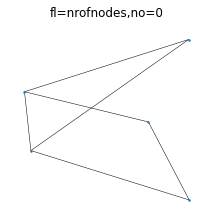

[0, 1, 2, 3]


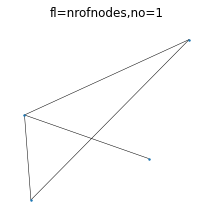

[0, 1, 2, 3]


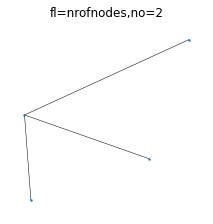

[0, 1, 2, 3]


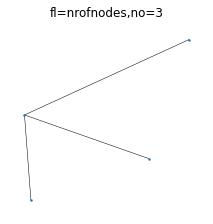

[0, 1, 2, 3]


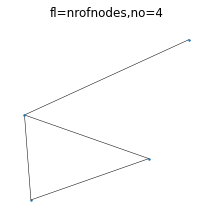

[0, 1, 2, 3]


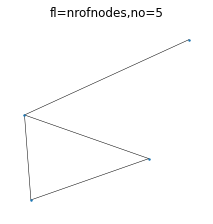

[0, 1, 2, 3]


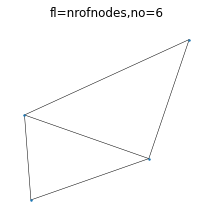

[0, 2, 3, 4]


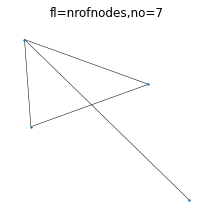

[0, 2, 3, 4]


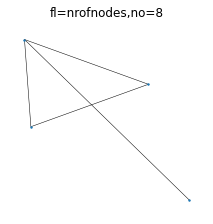

[0, 2, 3, 4]


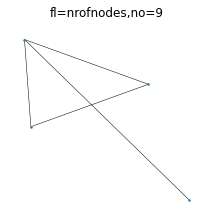

[0, 2, 3, 4]


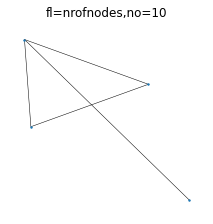

[0, 1, 2, 3, 4]


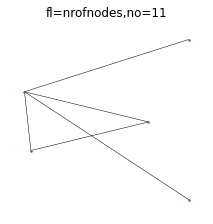

[0, 2, 3, 4]


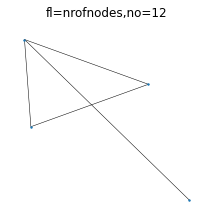

[0, 2, 3, 4]


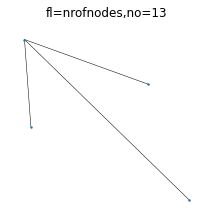

[0, 2, 3, 4]


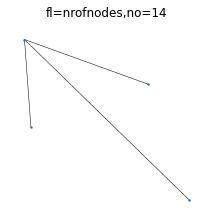

[0, 2, 3, 4]


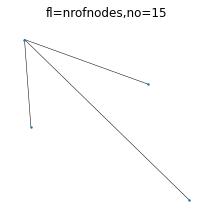

[0, 2, 3, 4]


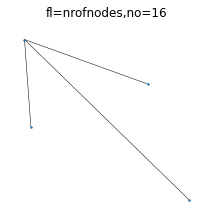

[0, 2, 3, 4]


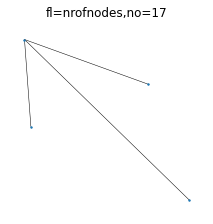

[0, 2, 3, 4]


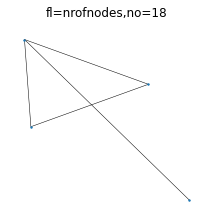

[0, 1, 2, 3, 4]


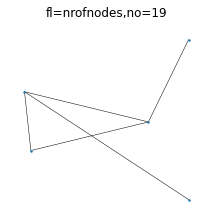

[0, 1, 2, 3, 4]


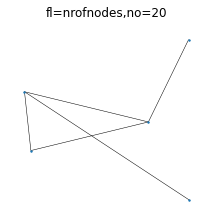

[0, 1, 2, 3]


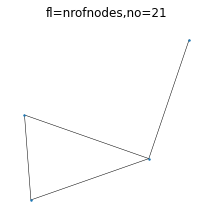

[0, 1, 2, 3]


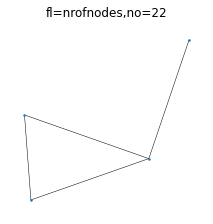

[0, 1, 2, 3]


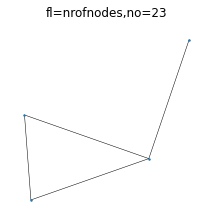

[0, 1, 2, 3, 4]


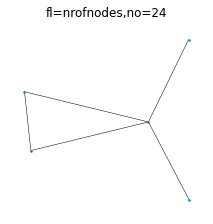

[0, 1, 2, 3, 4]


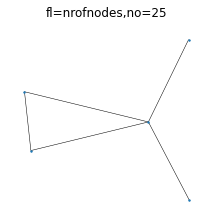

[0, 1, 2, 3, 4]


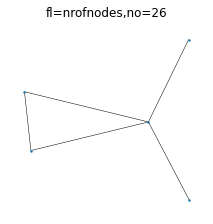

[0, 1, 2, 3, 4]


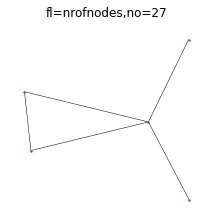

[0, 1, 2, 3, 4]


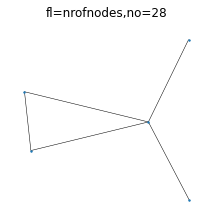

[0, 1, 2, 3, 4]


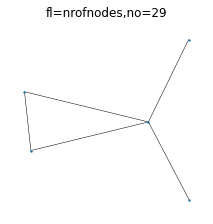

[0, 1, 2, 3, 4]


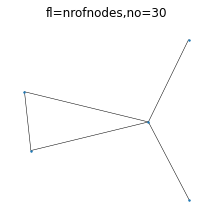

[0, 1, 2, 3, 4]


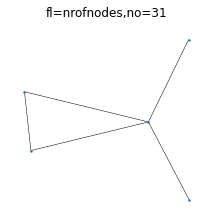

[0, 1, 2, 3, 4]


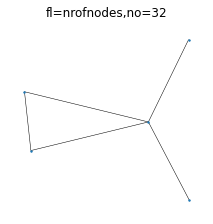

40 32
Time computing degree mmd:  0:00:00.588345
{'degree': 0.024918552817275952}
Time computing clustering mmd:  0:00:03.553845
{'degree': 0.024918552817275952, 'cluster': 0.04381857288269553}
-------------------------
[2.4004494  4.55036754 2.27518377 1.39474849 0.5328543  0.5328543
 9.54625673 3.18208558 0.8077381  1.22582347 2.45164693 1.22582347
 1.27318346 1.27318346 0.40502165]
...
[2.39623675 3.47201861 1.7360093  1.37054768 0.3274531  0.3274531
 5.64032946 1.88010982 0.04910714 0.96410586 1.92821172 0.96410586
 0.76284861 0.76284861 0.30664821]
-------------------------
{'degree': 0.024918552817275952, 'cluster': 0.04381857288269553, 'orbit': 0.004607975110116458}
{'degree': 0.024918552817275952, 'cluster': 0.04381857288269553, 'orbit': 0.004607975110116458}
0.0
[({'degree': 0.024918552817275952, 'cluster': 0.04381857288269553, 'orbit': 0.004607975110116458}, 0.0)]
cuda
3
843.0296838283539
{0: array([ 0.02621364, -0.0113256 ]), 1: array([-0.08029709, -0.00375137]), 2: array([-

<Figure size 1800x1800 with 0 Axes>

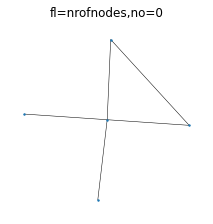

[0, 1, 2, 3, 4]


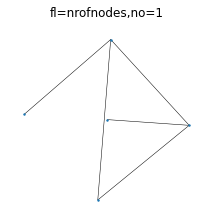

[0, 1, 2, 3, 4]


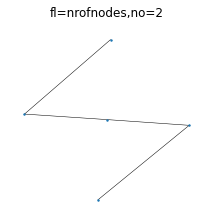

[0, 1, 3, 4]


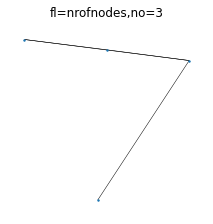

[0, 1, 3, 4]


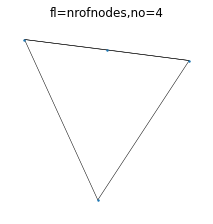

[0, 1, 3, 4]


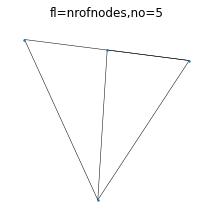

[0, 1, 3, 4]


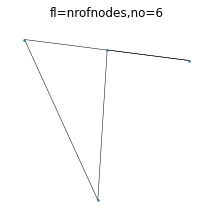

[0, 1, 3, 4]


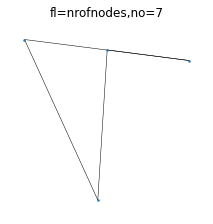

[0, 1, 3, 4]


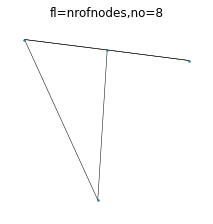

[0, 1, 3, 4]


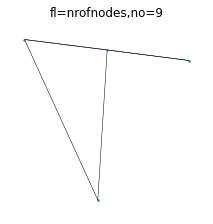

[0, 1, 3, 4]


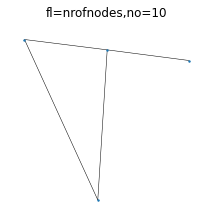

[0, 1, 3, 4]


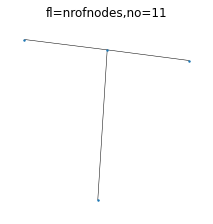

[0, 1, 2, 3]


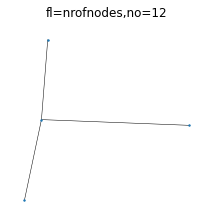

[0, 1, 2, 3]


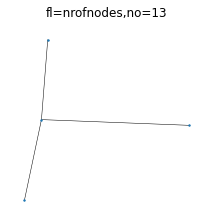

[0, 1, 2, 3, 4]


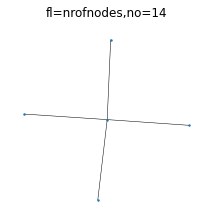

[0, 1, 2, 3, 4]


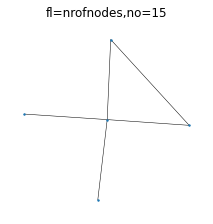

[0, 1, 2, 3, 4]


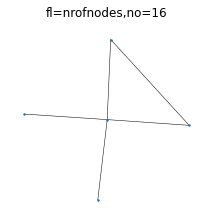

[0, 1, 2, 3, 4]


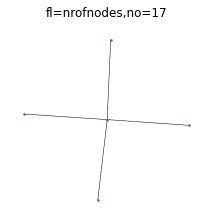

[0, 1, 2, 3, 4]


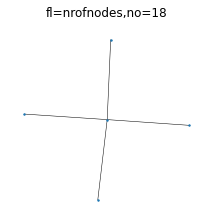

[0, 1, 2, 3, 4]


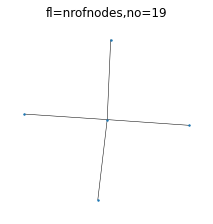

[0, 1, 2, 3, 4]


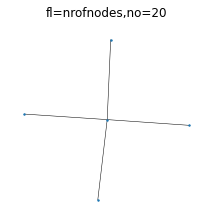

[0, 1, 2, 3, 4]


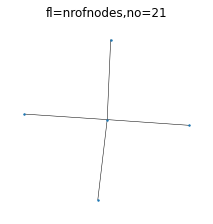

[0, 1, 2, 3, 4]


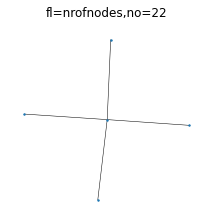

[0, 1, 2, 3, 4]


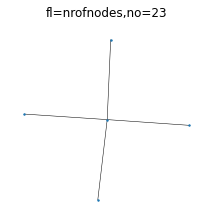

[0, 1, 2, 3, 4]


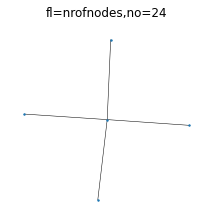

[0, 1, 2, 3, 4]


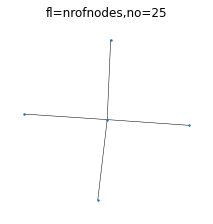

[0, 1, 2, 3, 4]


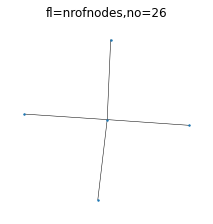

[0, 1, 2, 3, 4]


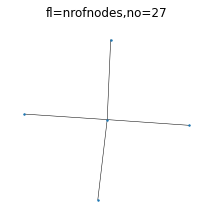

[0, 1, 2, 3, 4]


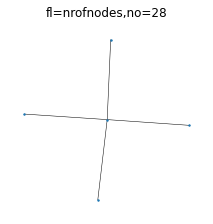

[0, 1, 2, 3, 4]


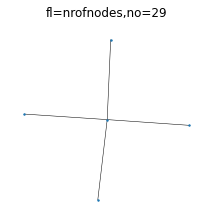

[0, 1, 2, 3, 4]


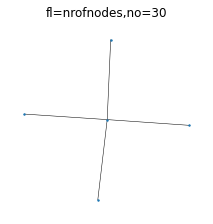

[0, 1, 2, 3, 4]


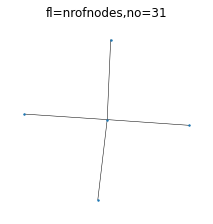

[0, 1, 2, 3, 4]


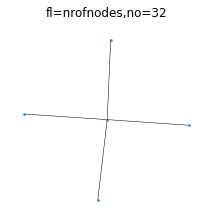

40 32
Time computing degree mmd:  0:00:00.594946
{'degree': 0.03217534458769822}
Time computing clustering mmd:  0:00:03.564465
{'degree': 0.03217534458769822, 'cluster': 0.06412826895193008}
-------------------------
[2.4004494  4.55036754 2.27518377 1.39474849 0.5328543  0.5328543
 9.54625673 3.18208558 0.8077381  1.22582347 2.45164693 1.22582347
 1.27318346 1.27318346 0.40502165]
...
[2.43684284 4.03326751 2.01663376 1.49297148 0.67070404 0.67070404
 6.96341276 2.32113759 0.33571897 1.64166302 3.28332605 1.64166302
 1.2340035  1.2340035  0.41186626]
-------------------------
{'degree': 0.03217534458769822, 'cluster': 0.06412826895193008, 'orbit': 0.006491372475406099}
{'degree': 0.03217534458769822, 'cluster': 0.06412826895193008, 'orbit': 0.006491372475406099}
0.0
[({'degree': 0.024918552817275952, 'cluster': 0.04381857288269553, 'orbit': 0.004607975110116458}, 0.0), ({'degree': 0.03217534458769822, 'cluster': 0.06412826895193008, 'orbit': 0.006491372475406099}, 0.0)]
cuda
3


KeyboardInterrupt: 

In [11]:
from argparse import Namespace
import networkx as nx
import sys
from utils.graph_utils import discretenoise, generate_mask, discretenoise_balanced_single, discretenoise_balanced, discretenoise_single_density


#args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_8.5_14:49/gridsearch_ppgn_consec_trees_60_200_pkl_6,16_7_32.yaml', log_level='INFO', comment='')
args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_15.5_17:51/gridsearch_ppgn_consec_ego_18_small_6,32_5_32_density_True.yaml', log_level='INFO', comment='')
#args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_16.5_21:37/gridsearch_ppgn_consec_sbm_27_200_pkl_6,32_5_32_density_True.yaml', log_level='INFO', comment='')


ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)
#
(config_dict)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-05-01-52-51_19452/models/best",1,16)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-05-01-52-52_6702/models",1,100)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-08-14-50-33_10454/models",1,10)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-08-19-38-45_12711/models",1,16)

#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-10-14-22-20_12504/models",1,12)
enablePrint()
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-15-17-51-42_4432/models",1,12)
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-15-17-51-42_12636/models",1,10)


#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-16-10-53-22_29189/models",1,8)
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-16-10-53-21_19805/models",1,4)


#a=sample_main_bala(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-17-13-59-41_24299/models",1,12)
#a=sample_main_bala(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-17-13-59-41_2595/models",1,32)

#a=sample_main_density(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-16-22-32-58_18486/models",1,16)



#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-28-15-30-20_9893/models",1,32)

#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-24-00-15-02_16543/models/best",1,1000)

##kld with sbm
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-28-22-48-41_20431/models",1,128)
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-28-22-48-58_4319/models",1,32)
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-29-15-52-32_30248/models",1,32)




##this is to test a good new ego and its best
sque
for i in range(1,1):
    print(1)
    #a = sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-29-22-01-51_19027/models/best",1,64)
    #b = sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-29-22-01-51_19027/models/bestloss",1,1000)
    #best.append(a)
    #bestloss.append(b)
    #print(b)


for i in range(1,5):
    bestloss.append(sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__Jun-03-10-38-49_23391/models",1,32))
    enablePrint()
    print(bestloss)
    bestloss.append(sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__Jun-03-10-39-23_31039/models",1,32))
    enablePrint()
    print(bestloss)
    bestloss.append(sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__Jun-03-10-39-23_31039/models",1,32))
    enablePrint()
    print(bestloss)
    print(i)

##cosine epoch 1000
#sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__Jun-01-15-00-29_9720/models",1,32)



    





In [9]:
bestloss

[({'degree': 0.01716478564239443,
   'cluster': 0.02601001612574122,
   'orbit': 0.005177576763972125},
  0.0),
 ({'degree': 0.02359587102842786,
   'cluster': 0.02671909954127394,
   'orbit': 0.008383544987011549},
  0.0),
 ({'degree': 0.02056168006547976,
   'cluster': 0.026462307756313086,
   'orbit': 0.009726398219183308},
  0.0)]

In [9]:
bestloss
##this is with bestloss

[({'degree': 0.0442345735387879,
   'cluster': 0.06312135359710597,
   'orbit': 0.002640061615707845},
  0.0)]

In [11]:
bestloss

[({'degree': 0.09571405820215195,
   'cluster': 0.09435165370992565,
   'orbit': 0.014834001495007465},
  0.0),
 ({'degree': 0.02323899780563843,
   'cluster': 0.05094536496654173,
   'orbit': 0.014499257181128433},
  0.0)]

In [12]:
bestloss

[({'degree': 0.024918552817275952,
   'cluster': 0.04381857288269553,
   'orbit': 0.004607975110116458},
  0.0),
 ({'degree': 0.03217534458769822,
   'cluster': 0.06412826895193008,
   'orbit': 0.006491372475406099},
  0.0)]

In [89]:
a

{'degree': 0.1317003218520998,
 'cluster': 0.48106094980463676,
 'orbit': 0.0,
 'likelyhood': 0.8344706186059312}

In [92]:
def cancel_middles(input_tensor):
    torch.eye(3)
    

In [ ]:
018154416214272384, 'cluster': 0.04154970107828421

In [9]:
bestloss

[{'degree': 0.021975652738437823,
  'cluster': 0.04287299330157446,
  'orbit': 0.0},
 {'degree': 0.016675296985108945,
  'cluster': 0.02958069623427212,
  'orbit': 0.0},
 {'degree': 0.015465714118674923,
  'cluster': 0.026155792776236253,
  'orbit': 0.0},
 {'degree': 0.01787601555535634, 'cluster': 0.02488237306093599, 'orbit': 0.0},
 {'degree': 0.02144023906327619, 'cluster': 0.02426539743160472, 'orbit': 0.0}]

In [ ]:
0.016
0.02785

In [11]:
bestloss

[{'degree': 0.015637630460565655, 'cluster': 0.0185772939523568, 'orbit': 0.0}]

In [13]:
bestloss

[{'degree': 0.012816200435843195,
  'cluster': 0.029621159545527243,
  'orbit': 0.0}]

cuda
3
658.518661737442
{0: array([0.10440085, 0.17485405]), 1: array([0.02111643, 0.27690393]), 2: array([0.06011265, 0.22301576]), 3: array([-0.00484811,  0.17103077]), 4: array([0.09444945, 0.30272876]), 5: array([0.14557885, 0.24508337]), 6: array([-0.01489962, -0.90427855]), 7: array([-0.40064305, -0.90011646]), 8: array([ 0.76532165, -0.72748876]), 9: array([-0.81671109,  0.59554832]), 10: array([1.        , 0.41741101]), 11: array([ 0.91948809, -0.20689153]), 12: array([-0.67909164, -0.57745119]), 13: array([ 0.38665769, -0.80179797]), 14: array([-0.95195765,  0.10557089]), 15: array([-0.41237601,  0.89732844]), 16: array([-0.79121475, -0.20215588]), 17: array([0.57461626, 0.91070505])}
[0, 1, 2, 3, 4, 5]


<Figure size 1800x1800 with 0 Axes>

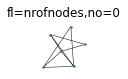

[0, 1, 2, 3, 4, 5]


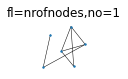

[0, 1, 2, 3, 4, 5]


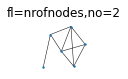

[0, 1, 2, 3, 4, 5]


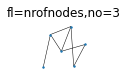

[0, 1, 2, 4, 5]


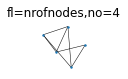

[0, 1, 2, 4, 5]


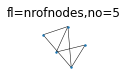

[0, 1, 2, 4, 5]


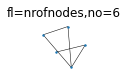

[0, 1, 2, 3, 4, 5]


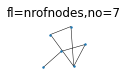

[0, 1, 2, 3, 4, 5]


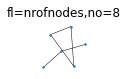

[0, 1, 2, 3, 4, 5]


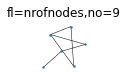

[0, 1, 2, 3, 4, 5]


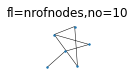

[0, 1, 2, 3, 4, 5]


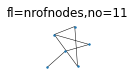

[0, 1, 2, 3, 4, 5]


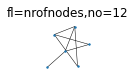

[0, 1, 2, 3, 4, 5]


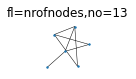

[0, 1, 2, 3, 4, 5]


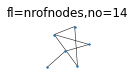

[0, 1, 2, 3, 4, 5]


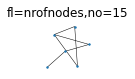

[0, 1, 2, 3, 4, 5]


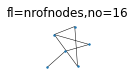

[0, 1, 2, 3, 4, 5]


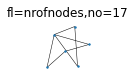

[0, 1, 2, 3, 4, 5]


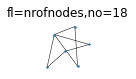

[0, 1, 2, 3, 4, 5]


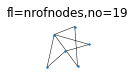

[0, 1, 2, 3, 4, 5]


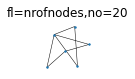

[0, 1, 2, 3, 4, 5]


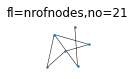

[0, 1, 2, 3, 4, 5]


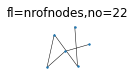

[0, 1, 2, 3, 4, 5]


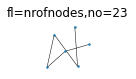

[0, 1, 2, 3, 4, 5]


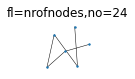

[0, 1, 2, 3, 4, 5]


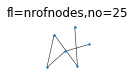

[0, 1, 2, 3, 4, 5]


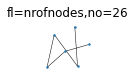

[0, 1, 2, 3, 4, 5]


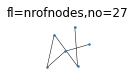

[0, 1, 2, 3, 4, 5]


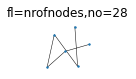

[0, 1, 2, 3, 4, 5]


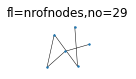

[0, 1, 2, 3, 4, 5]


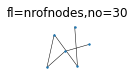

[0, 1, 2, 3, 4, 5]


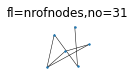

[0, 1, 2, 3, 4, 5]


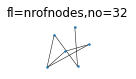

[0, 1, 2, 3, 4, 5]


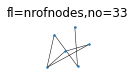

[0, 1, 2, 3, 4, 5]


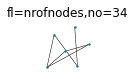

[0, 1, 2, 3, 4, 5]


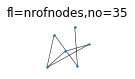

[0, 1, 2, 3, 4, 5]


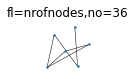

[0, 1, 2, 3, 4, 5]


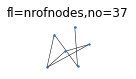

[0, 1, 2, 3, 4, 5]


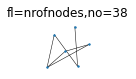

[0, 1, 2, 3, 4, 5]


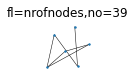

[0, 1, 2, 3, 4, 5]


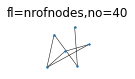

[0, 1, 2, 3, 4, 5]


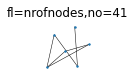

[0, 1, 2, 3, 4, 5]


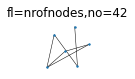

[0, 1, 2, 3, 4, 5]


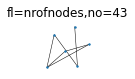

[0, 1, 2, 3, 4, 5]


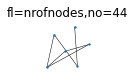

[0, 1, 2, 3, 4, 5]


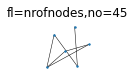

[0, 1, 2, 3, 4, 5]


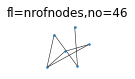

[0, 1, 2, 3, 4, 5]


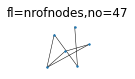

[0, 1, 2, 3, 4, 5]


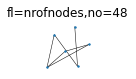

[0, 1, 2, 3, 4, 5]


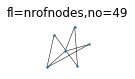

[0, 1, 2, 3, 4, 5]


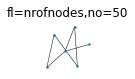

[0, 1, 2, 3, 4, 5]


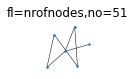

[0, 1, 2, 3, 4, 5]


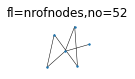

[0, 1, 2, 3, 4, 5]


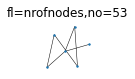

[0, 1, 2, 3, 4, 5]


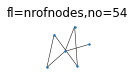

[0, 1, 2, 3, 4, 5]


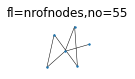

[0, 1, 2, 3, 4, 5]


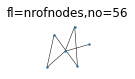

[0, 1, 2, 3, 4, 5]


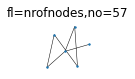

[0, 1, 2, 3, 4, 5]


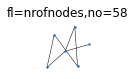

[0, 1, 2, 3, 4, 5]


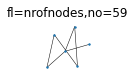

[0, 1, 2, 3, 4, 5]


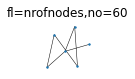

[0, 1, 2, 3, 4, 5]


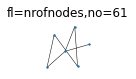

[0, 1, 2, 3, 4, 5]


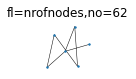

[0, 1, 2, 3, 4, 5]


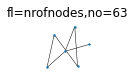

[0, 1, 2, 3, 4, 5]


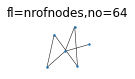

[0, 1, 2, 3, 4, 5]


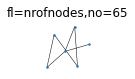

[0, 1, 2, 3, 4, 5]


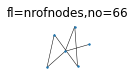

[0, 1, 2, 3, 4, 5]


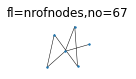

[0, 1, 2, 3, 4, 5]


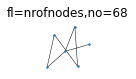

[0, 1, 2, 3, 4, 5]


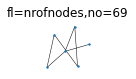

[0, 1, 2, 3, 4, 5]


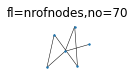

[0, 1, 2, 3, 4, 5]


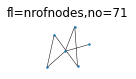

[0, 1, 2, 3, 4, 5]


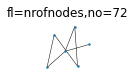

[0, 1, 2, 3, 4, 5]


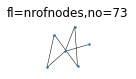

[0, 1, 2, 3, 4, 5]


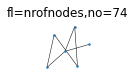

[0, 1, 2, 3, 4, 5]


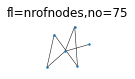

[0, 1, 2, 3, 4, 5]


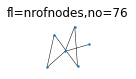

[0, 1, 2, 3, 4, 5]


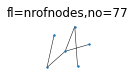

[0, 1, 2, 3, 4, 5]


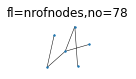

[0, 1, 2, 3, 4, 5]


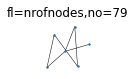

[0, 1, 2, 3, 4, 5]


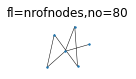

[0, 1, 2, 3, 4, 5]


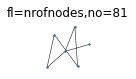

[0, 1, 2, 3, 4, 5]


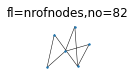

[0, 1, 2, 3, 4, 5]


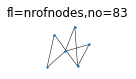

[0, 1, 2, 3, 4, 5]


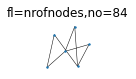

[0, 1, 2, 3, 4, 5]


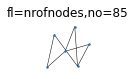

[0, 1, 2, 3, 4, 5]


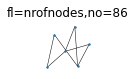

[0, 1, 2, 3, 4, 5]


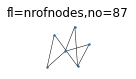

[0, 1, 2, 3, 4, 5]


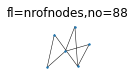

[0, 1, 2, 3, 4, 5]


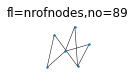

[0, 1, 2, 3, 4, 5]


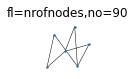

[0, 1, 2, 3, 4, 5]


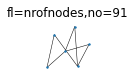

[0, 1, 2, 3, 4, 5]


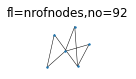

[0, 1, 2, 3, 4, 5]


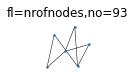

[0, 1, 2, 3, 4, 5]


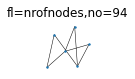

[0, 1, 2, 3, 4, 5]


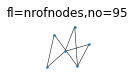

[0, 1, 2, 3, 4, 5]


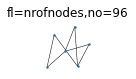

[0, 1, 2, 3, 4, 5]


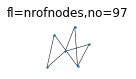

[0, 1, 2, 3, 4, 5]


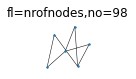

[0, 1, 2, 3, 4, 5]


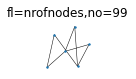

[0, 1, 2, 3, 4, 5]


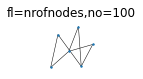

[0, 1, 2, 3, 4, 5]


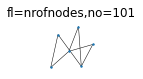

[0, 1, 2, 3, 4, 5]


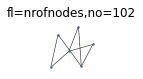

[0, 1, 2, 3, 4, 5]


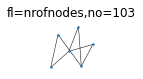

[0, 1, 2, 3, 4, 5]


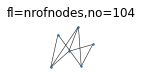

[0, 1, 2, 3, 4, 5]


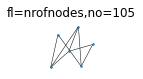

[0, 1, 2, 3, 4, 5]


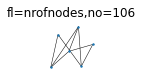

[0, 1, 2, 3, 4, 5]


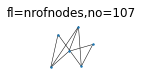

[0, 1, 2, 3, 4, 5]


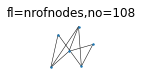

[0, 1, 2, 3, 4, 5]


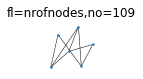

[0, 1, 2, 3, 4, 5]


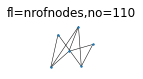

[0, 1, 2, 3, 4, 5]


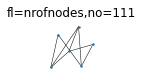

[0, 1, 2, 3, 4, 5]


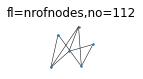

[0, 1, 2, 3, 4, 5]


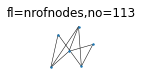

[0, 1, 2, 3, 4, 5]


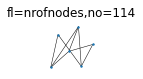

[0, 1, 2, 3, 4, 5]


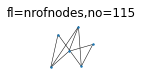

[0, 1, 2, 3, 4, 5]


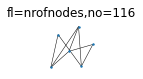

[0, 1, 2, 3, 4, 5]


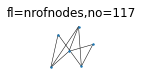

[0, 1, 2, 3, 4, 5]


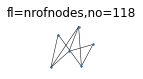

[0, 1, 2, 3, 4, 5]


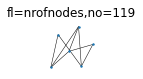

[0, 1, 2, 3, 4, 5]


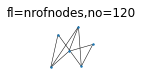

[0, 1, 2, 3, 4, 5]


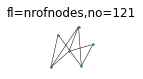

[0, 1, 2, 3, 4, 5]


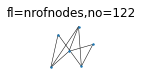

[0, 1, 2, 3, 4, 5]


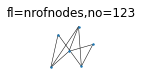

[0, 1, 2, 3, 4, 5]


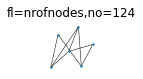

[0, 1, 2, 3, 4, 5]


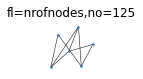

[0, 1, 2, 3, 4, 5]


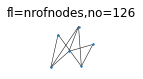

[0, 1, 2, 3, 4, 5]


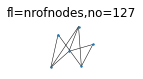

[0, 1, 2, 3, 4, 5]


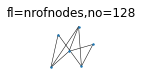

[0, 1, 2, 3, 4, 5]


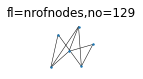

[0, 1, 2, 3, 4, 5]


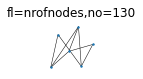

[0, 1, 2, 3, 4, 5]


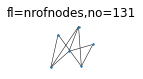

[0, 1, 2, 3, 4, 5]


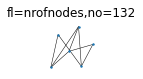

[0, 1, 2, 3, 4, 5]


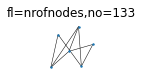

[0, 1, 2, 3, 4, 5]


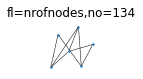

[0, 1, 2, 3, 4, 5]


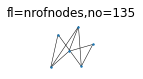

[0, 1, 2, 3, 4, 5]


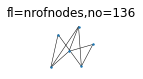

[0, 1, 2, 3, 4, 5]


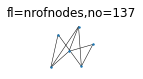

[0, 1, 2, 3, 4, 5]


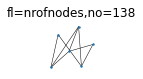

[0, 1, 2, 3, 4, 5]


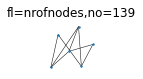

[0, 1, 2, 3, 4, 5]


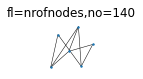

[0, 1, 2, 3, 4, 5]


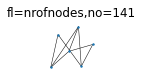

[0, 1, 2, 3, 4, 5]


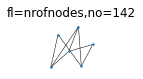

[0, 1, 2, 3, 4, 5]


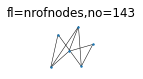

[0, 1, 2, 3, 4, 5]


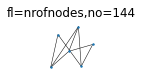

[0, 1, 2, 3, 4, 5]


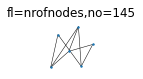

[0, 1, 2, 3, 4, 5]


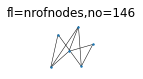

[0, 1, 2, 3, 4, 5]


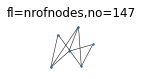

[0, 1, 2, 3, 4, 5]


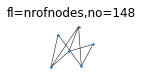

[0, 1, 2, 3, 4, 5]


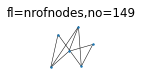

[0, 1, 2, 3, 4, 5]


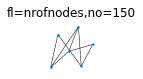

[0, 1, 2, 3, 4, 5]


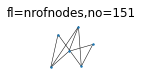

[0, 1, 2, 3, 4, 5]


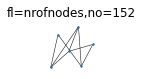

[0, 1, 2, 3, 4, 5]


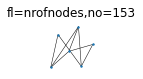

[0, 1, 2, 3, 4, 5]


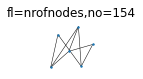

[0, 1, 2, 3, 4, 5]


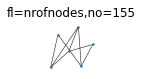

[0, 1, 2, 3, 4, 5]


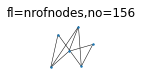

[0, 1, 2, 3, 4, 5]


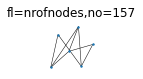

[0, 1, 2, 3, 4, 5]


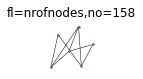

[0, 1, 2, 3, 4, 5]


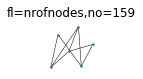

[0, 1, 2, 3, 4, 5]


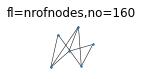

[0, 1, 2, 3, 4, 5]


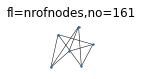

[0, 1, 2, 3, 4, 5]


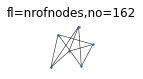

[0, 1, 2, 3, 4, 5]


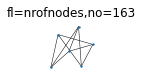

[0, 1, 2, 3, 4, 5]


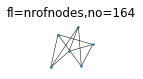

[0, 1, 2, 3, 4, 5]


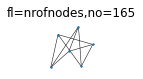

[0, 1, 2, 3, 4, 5]


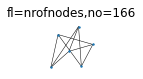

[0, 1, 2, 3, 4, 5]


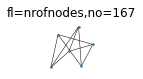

[0, 1, 2, 3, 4, 5]


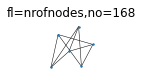

[0, 1, 2, 3, 4, 5]


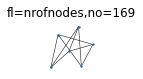

[0, 1, 2, 3, 4, 5]


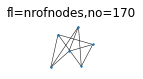

[0, 1, 2, 3, 4, 5]


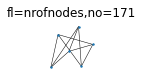

[0, 1, 2, 3, 4, 5]


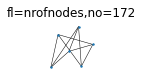

[0, 1, 2, 3, 4, 5]


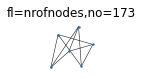

[0, 1, 2, 3, 4, 5]


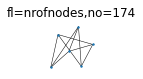

[0, 1, 2, 3, 4, 5]


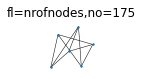

[0, 1, 2, 3, 4, 5]


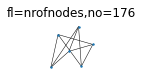

[0, 1, 2, 3, 4, 5]


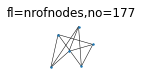

[0, 1, 2, 3, 4, 5]


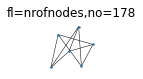

[0, 1, 2, 3, 4, 5]


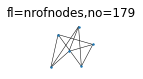

[0, 1, 2, 3, 4, 5]


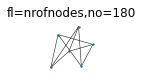

[0, 1, 2, 3, 4, 5]


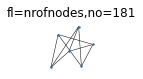

[0, 1, 2, 3, 4, 5]


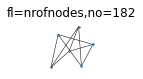

[0, 1, 2, 3, 4, 5]


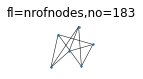

[0, 1, 2, 3, 4, 5]


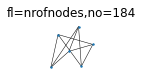

[0, 1, 2, 3, 4, 5]


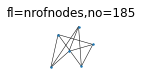

[0, 1, 2, 3, 4, 5]


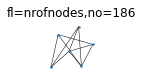

[0, 1, 2, 3, 4, 5]


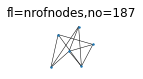

[0, 1, 2, 3, 4, 5]


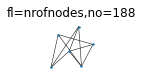

[0, 1, 2, 3, 4, 5]


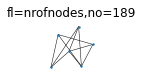

[0, 1, 2, 3, 4, 5]


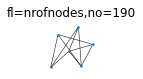

[0, 1, 2, 3, 4, 5]


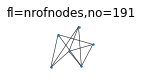

[0, 1, 2, 3, 4, 5]


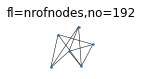

[0, 1, 2, 3, 4, 5]


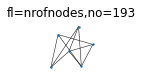

[0, 1, 2, 3, 4, 5]


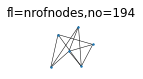

[0, 1, 2, 3, 4, 5]


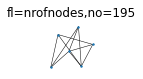

[0, 1, 2, 3, 4, 5]


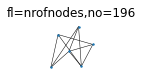

[0, 1, 2, 3, 4, 5]


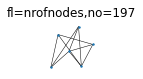

[0, 1, 2, 3, 4, 5]


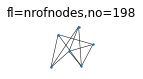

[0, 1, 2, 3, 4, 5]


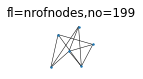

[0, 1, 2, 3, 4, 5]


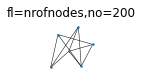

[0, 1, 2, 3, 4, 5]


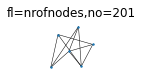

[0, 1, 2, 3, 4, 5]


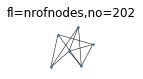

[0, 1, 2, 3, 4, 5]


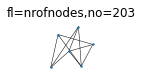

[0, 1, 2, 3, 4, 5]


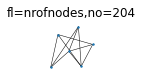

[0, 1, 2, 3, 4, 5]


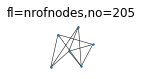

[0, 1, 2, 3, 4, 5]


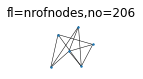

[0, 1, 2, 3, 4, 5]


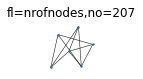

[0, 1, 2, 3, 4, 5]


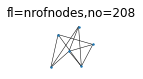

[0, 1, 2, 3, 4, 5]


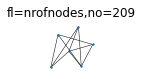

[0, 1, 2, 3, 4, 5]


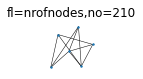

[0, 1, 2, 3, 4, 5]


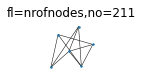

[0, 1, 2, 3, 4, 5]


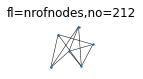

[0, 1, 2, 3, 4, 5]


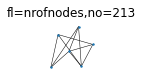

[0, 1, 2, 3, 4, 5]


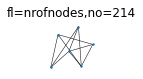

[0, 1, 2, 3, 4, 5]


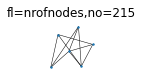

[0, 1, 2, 3, 4, 5]


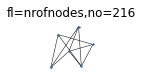

[0, 1, 2, 3, 4, 5]


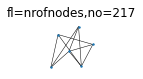

[0, 1, 2, 3, 4, 5]


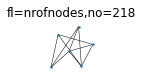

[0, 1, 2, 3, 4, 5]


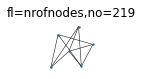

[0, 1, 2, 3, 4, 5]


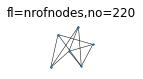

[0, 1, 2, 3, 4, 5]


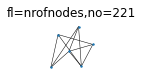

[0, 1, 2, 3, 4, 5]


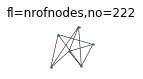

[0, 1, 2, 3, 4, 5]


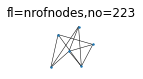

[0, 1, 2, 3, 4, 5]


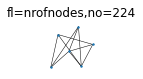

[0, 1, 2, 3, 4, 5]


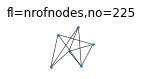

[0, 1, 2, 3, 4, 5]


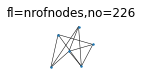

[0, 1, 2, 3, 4, 5]


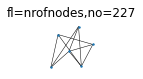

[0, 1, 2, 3, 4, 5]


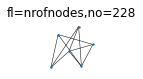

[0, 1, 2, 3, 4, 5]


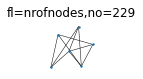

[0, 1, 2, 3, 4, 5]


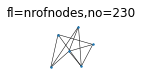

[0, 1, 2, 3, 4, 5]


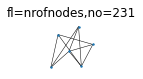

[0, 1, 2, 3, 4, 5]


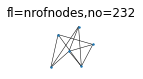

[0, 1, 2, 3, 4, 5]


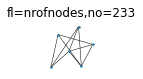

[0, 1, 2, 3, 4, 5]


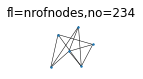

[0, 1, 2, 3, 4, 5]


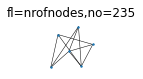

[0, 1, 2, 3, 4, 5]


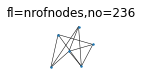

[0, 1, 2, 3, 4, 5]


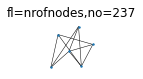

[0, 1, 2, 3, 4, 5]


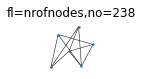

[0, 1, 2, 3, 4, 5]


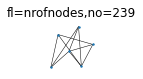

[0, 1, 2, 3, 4, 5]


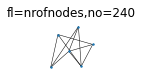

[0, 1, 2, 3, 4, 5]


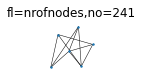

[0, 1, 2, 3, 4, 5]


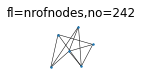

[0, 1, 2, 3, 4, 5]


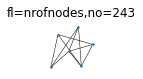

[0, 1, 2, 3, 4, 5]


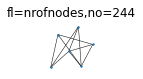

[0, 1, 2, 3, 4, 5]


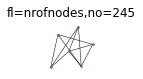

[0, 1, 2, 3, 4, 5]


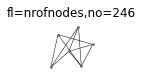

[0, 1, 2, 3, 4, 5]


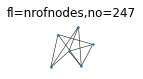

[0, 1, 2, 3, 4, 5]


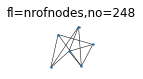

[0, 1, 2, 3, 4, 5]


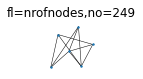

[0, 1, 2, 3, 4, 5]


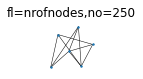

[0, 1, 2, 3, 4, 5]


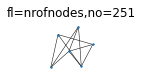

[0, 1, 2, 3, 4, 5]


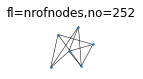

[0, 1, 2, 3, 4, 5]


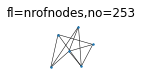

[0, 1, 2, 3, 4, 5]


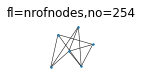

[0, 1, 2, 3, 4, 5]


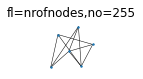

[0, 1, 2, 3, 4, 5]


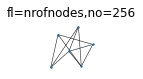

[0, 1, 2, 3, 4, 5]


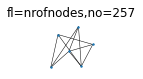

[0, 1, 2, 3, 4, 5]


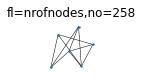

[0, 1, 2, 3, 4, 5]


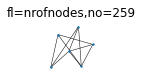

[0, 1, 2, 3, 4, 5]


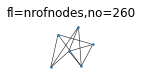

[0, 1, 2, 3, 4, 5]


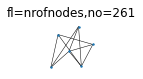

[0, 1, 2, 3, 4, 5]


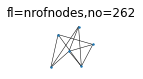

[0, 1, 2, 3, 4, 5]


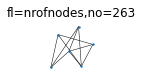

[0, 1, 2, 3, 4, 5]


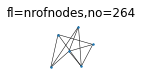

[0, 1, 2, 3, 4, 5]


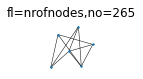

[0, 1, 2, 3, 4, 5]


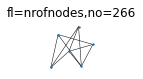

[0, 1, 2, 3, 4, 5]


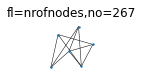

[0, 1, 2, 3, 4, 5]


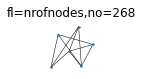

[0, 1, 2, 3, 4, 5]


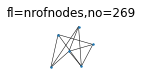

[0, 1, 2, 3, 4, 5]


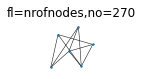

[0, 1, 2, 3, 4, 5]


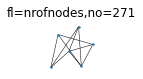

[0, 1, 2, 3, 4, 5]


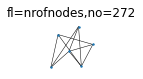

[0, 1, 2, 3, 4, 5]


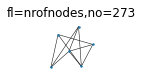

[0, 1, 2, 3, 4, 5]


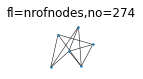

[0, 1, 2, 3, 4, 5]


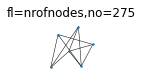

[0, 1, 2, 3, 4, 5]


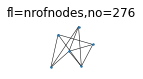

[0, 1, 2, 3, 4, 5]


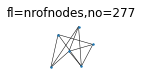

[0, 1, 2, 3, 4, 5]


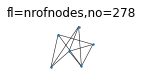

[0, 1, 2, 3, 4, 5]


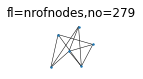

[0, 1, 2, 3, 4, 5]


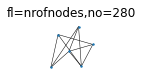

[0, 1, 2, 3, 4, 5]


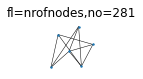

[0, 1, 2, 3, 4, 5]


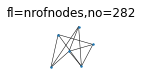

[0, 1, 2, 3, 4, 5]


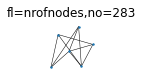

[0, 1, 2, 3, 4, 5]


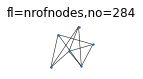

[0, 1, 2, 3, 4, 5]


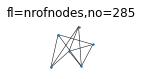

[0, 1, 2, 3, 4, 5]


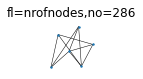

[0, 1, 2, 3, 4, 5]


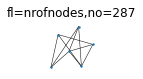

[0, 1, 2, 3, 4, 5]


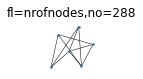

[0, 1, 2, 3, 4, 5]


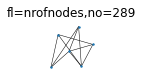

[0, 1, 2, 3, 4, 5]


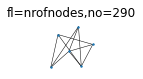

[0, 1, 2, 3, 4, 5]


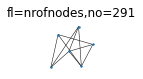

[0, 1, 2, 3, 4, 5]


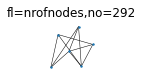

[0, 1, 2, 3, 4, 5]


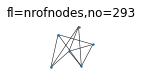

[0, 1, 2, 3, 4, 5]


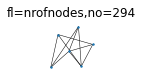

[0, 1, 2, 3, 4, 5]


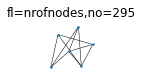

[0, 1, 2, 3, 4, 5]


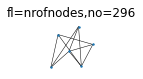

[0, 1, 2, 3, 4, 5]


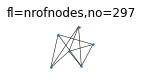

[0, 1, 2, 3, 4, 5]


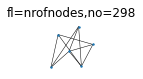

[0, 1, 2, 3, 4, 5]


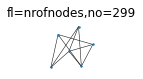

[0, 1, 2, 3, 4, 5]


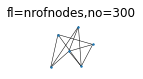

[0, 1, 2, 3, 4, 5]


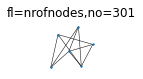

[0, 1, 2, 3, 4, 5]


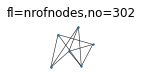

[0, 1, 2, 3, 4, 5]


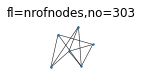

[0, 1, 2, 3, 4, 5]


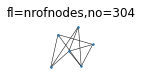

[0, 1, 2, 3, 4, 5]


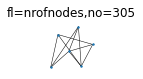

[0, 1, 2, 3, 4, 5]


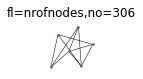

[0, 1, 2, 3, 4, 5]


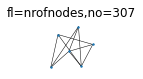

[0, 1, 2, 3, 4, 5]


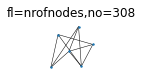

[0, 1, 2, 3, 4, 5]


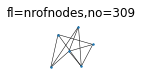

[0, 1, 2, 3, 4, 5]


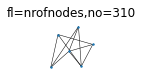

[0, 1, 2, 3, 4, 5]


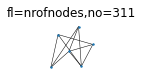

[0, 1, 2, 3, 4, 5]


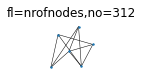

[0, 1, 2, 3, 4, 5]


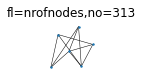

[0, 1, 2, 3, 4, 5]


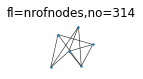

[0, 1, 2, 3, 4, 5]


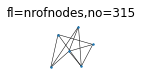

[0, 1, 2, 3, 4, 5]


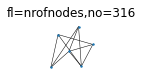

[0, 1, 2, 3, 4, 5]


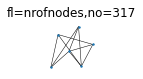

[0, 1, 2, 3, 4, 5]


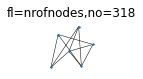

[0, 1, 2, 3, 4, 5]


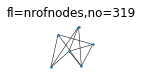

[0, 1, 2, 3, 4, 5]


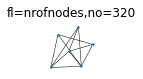

[0, 1, 2, 3, 4, 5]


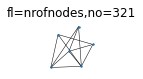

[0, 1, 2, 3, 4, 5]


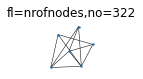

[0, 1, 2, 3, 4, 5]


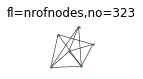

[0, 1, 2, 3, 4, 5]


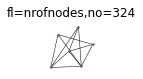

[0, 1, 2, 3, 4, 5]


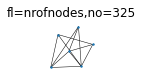

[0, 1, 2, 3, 4, 5]


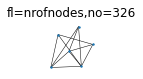

[0, 1, 2, 3, 4, 5]


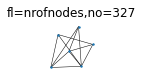

[0, 1, 2, 3, 4, 5]


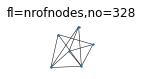

[0, 1, 2, 3, 4, 5]


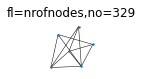

[0, 1, 2, 3, 4, 5]


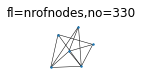

[0, 1, 2, 3, 4, 5]


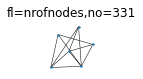

[0, 1, 2, 3, 4, 5]


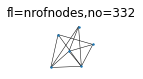

[0, 1, 2, 3, 4, 5]


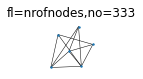

[0, 1, 2, 3, 4, 5]


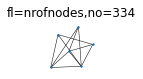

[0, 1, 2, 3, 4, 5]


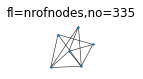

[0, 1, 2, 3, 4, 5]


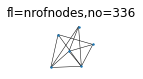

[0, 1, 2, 3, 4, 5]


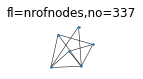

[0, 1, 2, 3, 4, 5]


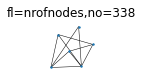

[0, 1, 2, 3, 4, 5]


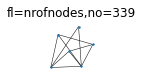

[0, 1, 2, 3, 4, 5]


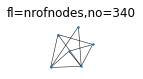

[0, 1, 2, 3, 4, 5]


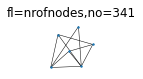

[0, 1, 2, 3, 4, 5]


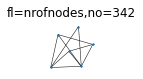

[0, 1, 2, 3, 4, 5]


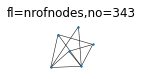

[0, 1, 2, 3, 4, 5]


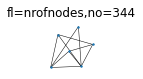

[0, 1, 2, 3, 4, 5]


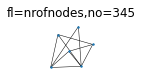

[0, 1, 2, 3, 4, 5]


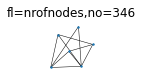

[0, 1, 2, 3, 4, 5]


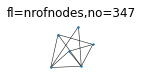

[0, 1, 2, 3, 4, 5]


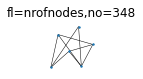

[0, 1, 2, 3, 4, 5]


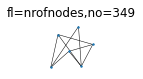

[0, 1, 2, 3, 4, 5]


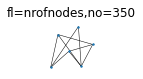

[0, 1, 2, 3, 4, 5]


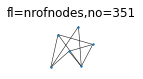

[0, 1, 2, 3, 4, 5]


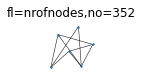

[0, 1, 2, 3, 4, 5]


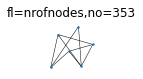

[0, 1, 2, 3, 4, 5]


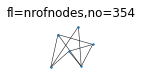

[0, 1, 2, 3, 4, 5]


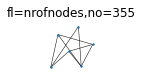

[0, 1, 2, 3, 4, 5]


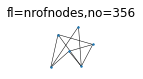

[0, 1, 2, 3, 4, 5]


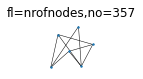

[0, 1, 2, 3, 4, 5]


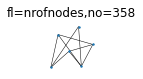

[0, 1, 2, 3, 4, 5]


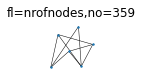

[0, 1, 2, 3, 4, 5]


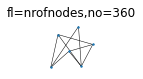

[0, 1, 2, 3, 4, 5]


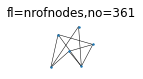

[0, 1, 2, 3, 4, 5]


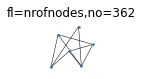

[0, 1, 2, 3, 4, 5]


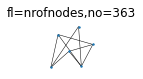

[0, 1, 2, 3, 4, 5]


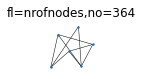

[0, 1, 2, 3, 4, 5]


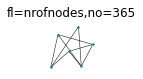

[0, 1, 2, 3, 4, 5]


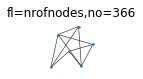

[0, 1, 2, 3, 4, 5]


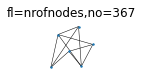

[0, 1, 2, 3, 4, 5]


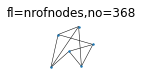

[0, 1, 2, 3, 4, 5]


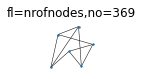

[0, 1, 2, 3, 4, 5]


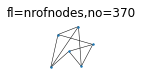

[0, 1, 2, 3, 4, 5]


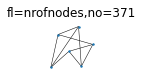

[0, 1, 2, 3, 4, 5]


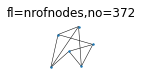

[0, 1, 2, 3, 4, 5]


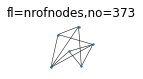

[0, 1, 2, 3, 4, 5]


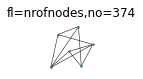

[0, 1, 2, 3, 4, 5]


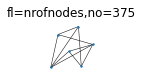

[0, 1, 2, 3, 4, 5]


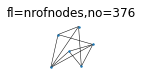

[0, 1, 2, 3, 4, 5]


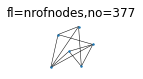

[0, 1, 2, 3, 4, 5]


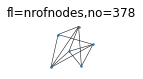

[0, 1, 2, 3, 4, 5]


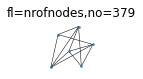

[0, 1, 2, 3, 4, 5]


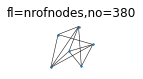

[0, 1, 2, 3, 4, 5]


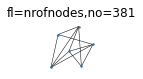

[0, 1, 2, 3, 4, 5]


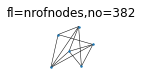

[0, 1, 2, 3, 4, 5]


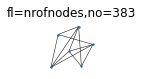

[0, 1, 2, 3, 4, 5]


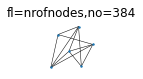

[0, 1, 2, 3, 4, 5]


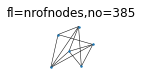

[0, 1, 2, 3, 4, 5]


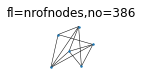

[0, 1, 2, 3, 4, 5]


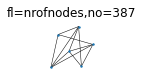

[0, 1, 2, 3, 4, 5]


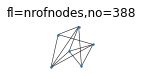

[0, 1, 2, 3, 4, 5]


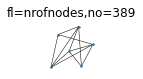

[0, 1, 2, 3, 4, 5]


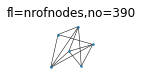

[0, 1, 2, 3, 4, 5]


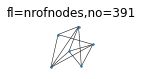

[0, 1, 2, 3, 4, 5]


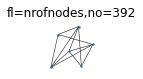

[0, 1, 2, 3, 4, 5]


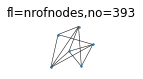

[0, 1, 2, 3, 4, 5]


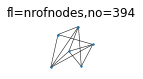

[0, 1, 2, 3, 4, 5]


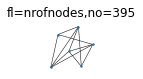

[0, 1, 2, 3, 4, 5]


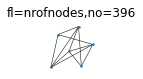

[0, 1, 2, 3, 4, 5]


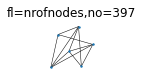

[0, 1, 2, 3, 4, 5]


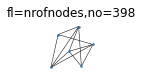

[0, 1, 2, 3, 4, 5]


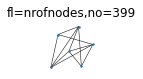

[0, 1, 2, 3, 4, 5]


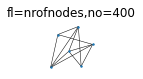

[0, 1, 2, 3, 4, 5]


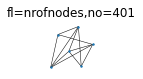

[0, 1, 2, 3, 4, 5]


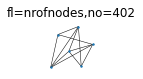

[0, 1, 2, 3, 4, 5]


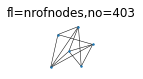

[0, 1, 2, 3, 4, 5]


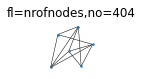

[0, 1, 2, 3, 4, 5]


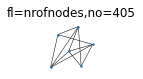

[0, 1, 2, 3, 4, 5]


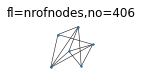

[0, 1, 2, 3, 4, 5]


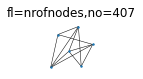

[0, 1, 2, 3, 4, 5]


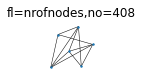

[0, 1, 2, 3, 4, 5]


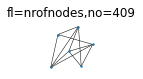

[0, 1, 2, 3, 4, 5]


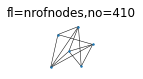

[0, 1, 2, 3, 4, 5]


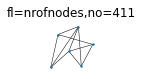

[0, 1, 2, 3, 4, 5]


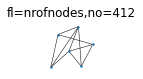

[0, 1, 2, 3, 4, 5]


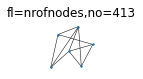

[0, 1, 2, 3, 4, 5]


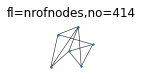

[0, 1, 2, 3, 4, 5]


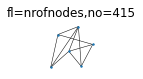

[0, 1, 2, 3, 4, 5]


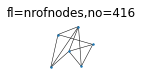

[0, 1, 2, 3, 4, 5]


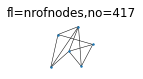

[0, 1, 2, 3, 4, 5]


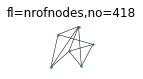

[0, 1, 2, 3, 4, 5]


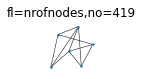

[0, 1, 2, 3, 4, 5]


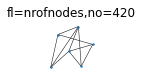

[0, 1, 2, 3, 4, 5]


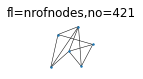

[0, 1, 2, 3, 4, 5]


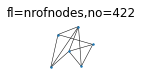

[0, 1, 2, 3, 4, 5]


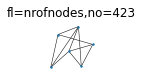

[0, 1, 2, 3, 4, 5]


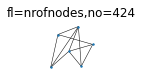

[0, 1, 2, 3, 4, 5]


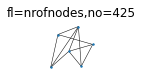

[0, 1, 2, 3, 4, 5]


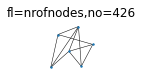

[0, 1, 2, 3, 4, 5]


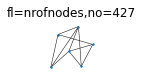

[0, 1, 2, 3, 4, 5]


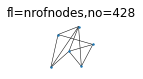

[0, 1, 2, 3, 4, 5]


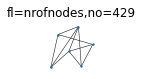

[0, 1, 2, 3, 4, 5]


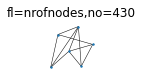

[0, 1, 2, 3, 4, 5]


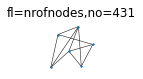

[0, 1, 2, 3, 4, 5]


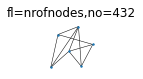

[0, 1, 2, 3, 4, 5]


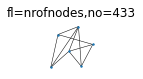

[0, 1, 2, 3, 4, 5]


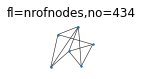

[0, 1, 2, 3, 4, 5]


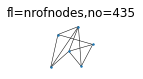

[0, 1, 2, 3, 4, 5]


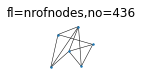

[0, 1, 2, 3, 4, 5]


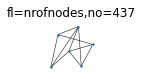

[0, 1, 2, 3, 4, 5]


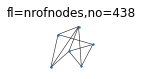

[0, 1, 2, 3, 4, 5]


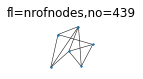

[0, 1, 2, 3, 4, 5]


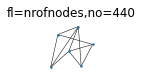

[0, 1, 2, 3, 4, 5]


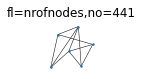

[0, 1, 2, 3, 4, 5]


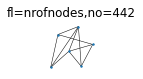

[0, 1, 2, 3, 4, 5]


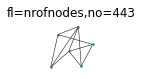

[0, 1, 2, 3, 4, 5]


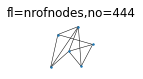

[0, 1, 2, 3, 4, 5]


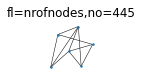

[0, 1, 2, 3, 4, 5]


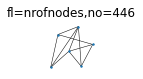

[0, 1, 2, 3, 4, 5]


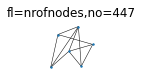

[0, 1, 2, 3, 4, 5]


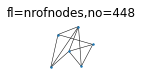

[0, 1, 2, 3, 4, 5]


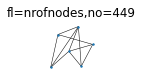

[0, 1, 2, 3, 4, 5]


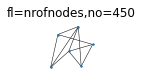

[0, 1, 2, 3, 4, 5]


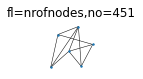

[0, 1, 2, 3, 4, 5]


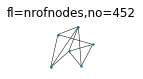

[0, 1, 2, 3, 4, 5]


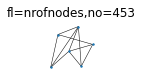

[0, 1, 2, 3, 4, 5]


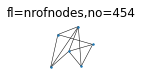

[0, 1, 2, 3, 4, 5]


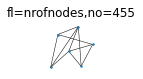

[0, 1, 2, 3, 4, 5]


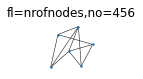

[0, 1, 2, 3, 4, 5]


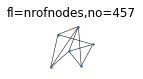

[0, 1, 2, 3, 4, 5]


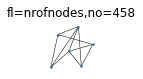

[0, 1, 2, 3, 4, 5]


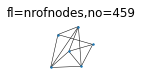

[0, 1, 2, 3, 4, 5]


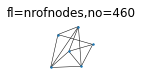

[0, 1, 2, 3, 4, 5]


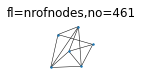

[0, 1, 2, 3, 4, 5]


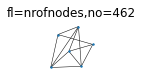

[0, 1, 2, 3, 4, 5]


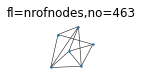

[0, 1, 2, 3, 4, 5]


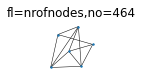

[0, 1, 2, 3, 4, 5]


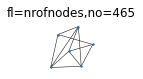

[0, 1, 2, 3, 4, 5]


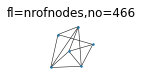

[0, 1, 2, 3, 4, 5]


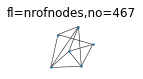

[0, 1, 2, 3, 4, 5]


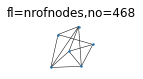

[0, 1, 2, 3, 4, 5]


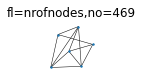

[0, 1, 2, 3, 4, 5]


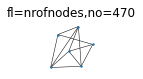

[0, 1, 2, 3, 4, 5]


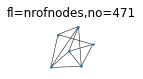

[0, 1, 2, 3, 4, 5]


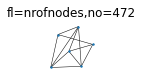

[0, 1, 2, 3, 4, 5]


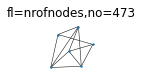

[0, 1, 2, 3, 4, 5]


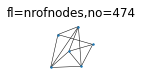

[0, 1, 2, 3, 4, 5]


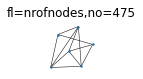

[0, 1, 2, 3, 4, 5]


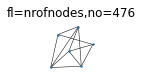

[0, 1, 2, 3, 4, 5]


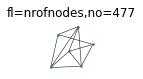

[0, 1, 2, 3, 4, 5]


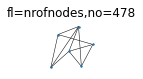

[0, 1, 2, 3, 4, 5]


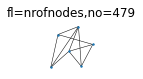

[0, 1, 2, 3, 4, 5]


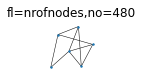

[0, 1, 2, 3, 4, 5]


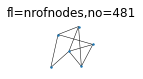

[0, 1, 2, 3, 4, 5]


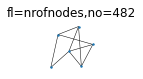

[0, 1, 2, 3, 4, 5]


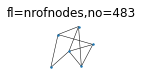

[0, 1, 2, 3, 4, 5]


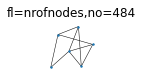

[0, 1, 2, 3, 4, 5]


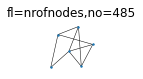

[0, 1, 2, 3, 4, 5]


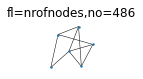

[0, 1, 2, 3, 4, 5]


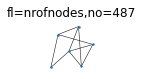

[0, 1, 2, 3, 4, 5]


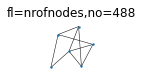

[0, 1, 2, 3, 4, 5]


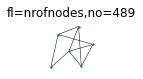

[0, 1, 2, 3, 4, 5]


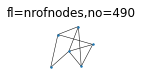

[0, 1, 2, 3, 4, 5]


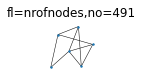

[0, 1, 2, 3, 4, 5]


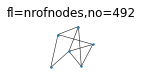

[0, 1, 2, 3, 4, 5]


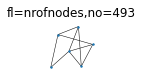

[0, 1, 2, 3, 4, 5]


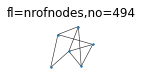

[0, 1, 2, 3, 4, 5]


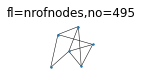

[0, 1, 2, 3, 4, 5]


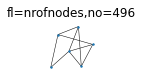

[0, 1, 2, 3, 4, 5]


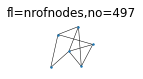

[0, 1, 2, 3, 4, 5]


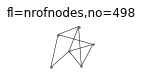

[0, 1, 2, 3, 4, 5]


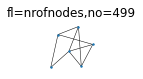

[0, 1, 2, 3, 4, 5]


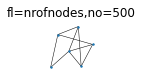

[0, 1, 2, 3, 4, 5]


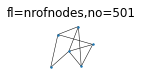

[0, 1, 2, 3, 4, 5]


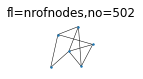

[0, 1, 2, 3, 4, 5]


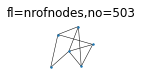

[0, 1, 2, 3, 4, 5]


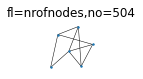

[0, 1, 2, 3, 4, 5]


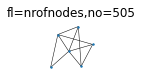

[0, 1, 2, 3, 4, 5]


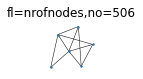

[0, 1, 2, 3, 4, 5]


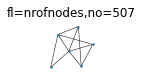

[0, 1, 2, 3, 4, 5]


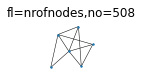

[0, 1, 2, 3, 4, 5]


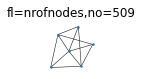

[0, 1, 2, 3, 4, 5]


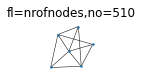

[0, 1, 2, 3, 4, 5]


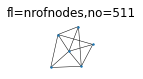

[0, 1, 2, 3, 4, 5]


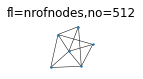

40 32
Time computing degree mmd:  0:00:00.562801
{'degree': 0.02930551555829708}
Time computing clustering mmd:  0:00:03.536934
{'degree': 0.02930551555829708, 'cluster': 0.028594642485752164}
cuda
3
690.2636761665344
{0: array([0.51329318, 0.33303837]), 1: array([0.33128869, 0.30312538]), 2: array([0.42792406, 0.26295531]), 3: array([0.45965612, 0.16306797]), 4: array([ 0.71433007, -0.82368157]), 5: array([-0.79101419, -0.00242067]), 6: array([-0.703041  , -0.55493075]), 7: array([0.01020137, 1.        ]), 8: array([0.98469693, 0.12294025]), 9: array([-0.11397675, -0.98574427]), 10: array([ 0.78179617, -0.50555952]), 11: array([ 0.28489737, -0.96318778]), 12: array([-0.47012851, -0.83560196]), 13: array([0.63693441, 0.76380061]), 14: array([-0.8513343 ,  0.34979306]), 15: array([-0.98248692, -0.28410567]), 16: array([-0.431034  ,  0.95151633]), 17: array([-0.80200271,  0.70499488])}
[1, 3]


<Figure size 1800x1800 with 0 Axes>

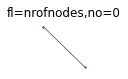

[0, 1, 2, 3]


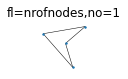

[0, 1, 2, 3]


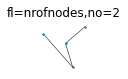

[0, 1, 2, 3]


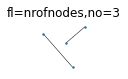

[0, 2]


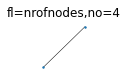

[0, 2]


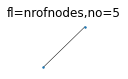

[0, 1, 2, 3]


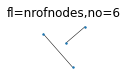

[0, 2]


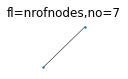

[0, 2]


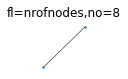

[0, 2]


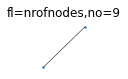

[0, 1, 2]


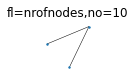

[0, 2]


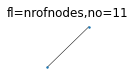

[0, 2]


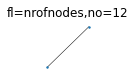

[0, 2]


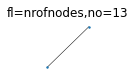

[0, 2]


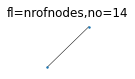

[0, 1, 2]


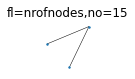

[0, 2]


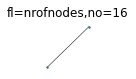

[0, 1, 2]


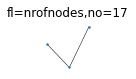

[0, 1, 2]


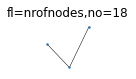

[0, 1, 2]


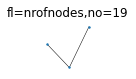

[0, 1, 2, 3]


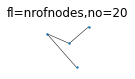

[0, 1, 2, 3]


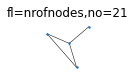

[0, 1, 2, 3]


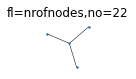

[0, 1, 2, 3]


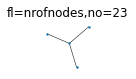

[0, 1, 2, 3]


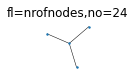

[0, 1, 2, 3]


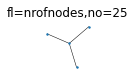

[0, 1, 2, 3]


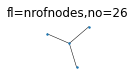

[0, 1, 2, 3]


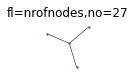

[0, 1, 2, 3]


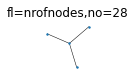

[0, 1, 2, 3]


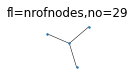

[0, 1, 2, 3]


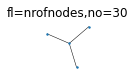

[0, 1, 2, 3]


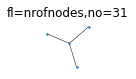

[0, 1, 2, 3]


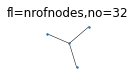

[0, 1, 2, 3]


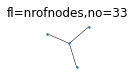

[0, 1, 2, 3]


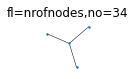

[0, 1, 2, 3]


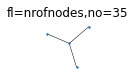

[0, 1, 2, 3]


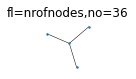

[0, 1, 2, 3]


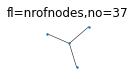

[0, 1, 2, 3]


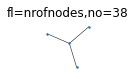

[0, 1, 2, 3]


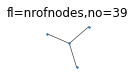

[0, 1, 2, 3]


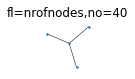

[0, 1, 2, 3]


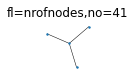

[0, 1, 2, 3]


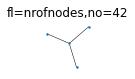

[0, 1, 2, 3]


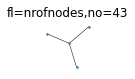

[0, 1, 2, 3]


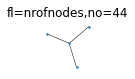

[0, 1, 2, 3]


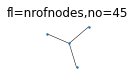

[0, 1, 2, 3]


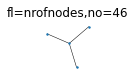

[0, 1, 2, 3]


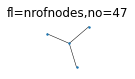

[0, 1, 2, 3]


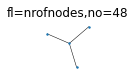

[0, 1, 2, 3]


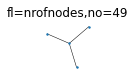

[0, 1, 2, 3]


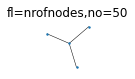

[0, 1, 2, 3]


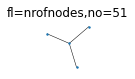

[0, 1, 2, 3]


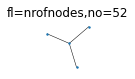

[0, 1, 2, 3]


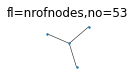

[0, 1, 2, 3]


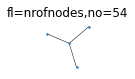

[0, 1, 2, 3]


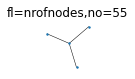

[0, 1, 2, 3]


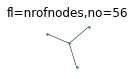

[0, 1, 2, 3]


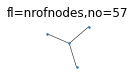

[0, 1, 2, 3]


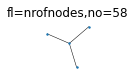

[0, 1, 2, 3]


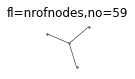

[0, 1, 2, 3]


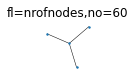

[0, 1, 2, 3]


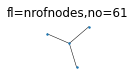

[0, 1, 2, 3]


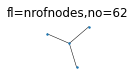

[0, 1, 2, 3]


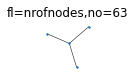

[0, 1, 2, 3]


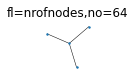

[0, 1, 2, 3]


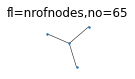

[0, 1, 2, 3]


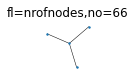

[0, 1, 2, 3]


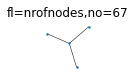

[0, 1, 2, 3]


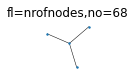

[0, 1, 2, 3]


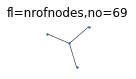

[0, 1, 2, 3]


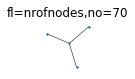

[0, 1, 2, 3]


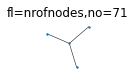

[0, 1, 2, 3]


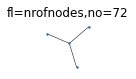

[0, 1, 2, 3]


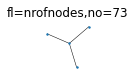

[0, 1, 2, 3]


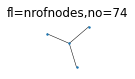

[0, 1, 2, 3]


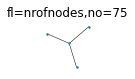

[0, 1, 2, 3]


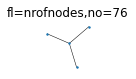

[0, 1, 2, 3]


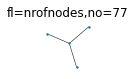

[0, 1, 2, 3]


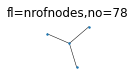

[0, 1, 2, 3]


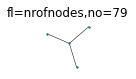

[0, 1, 2, 3]


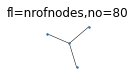

[0, 1, 2, 3]


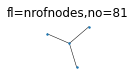

[0, 1, 2, 3]


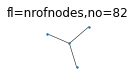

[0, 1, 2, 3]


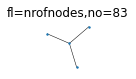

[0, 1, 2, 3]


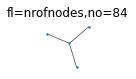

[0, 1, 2, 3]


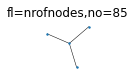

[0, 1, 2, 3]


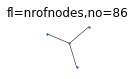

[0, 1, 2, 3]


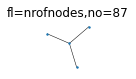

[0, 1, 2, 3]


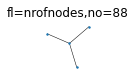

[0, 1, 2, 3]


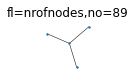

[0, 1, 2, 3]


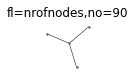

[0, 1, 2, 3]


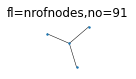

[0, 1, 2, 3]


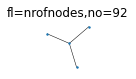

[0, 1, 2, 3]


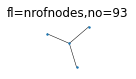

[0, 1, 2, 3]


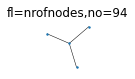

[0, 1, 2, 3]


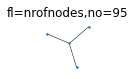

[0, 1, 2, 3]


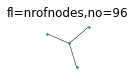

[0, 1, 2, 3]


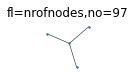

[0, 1, 2, 3]


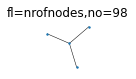

[0, 1, 2, 3]


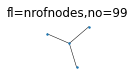

[0, 1, 2, 3]


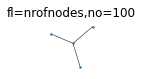

[0, 1, 2, 3]


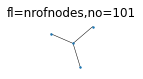

[0, 1, 2, 3]


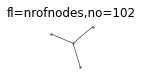

[0, 1, 2, 3]


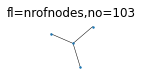

[0, 1, 2, 3]


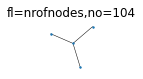

[0, 1, 2, 3]


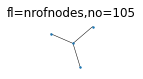

[0, 1, 2, 3]


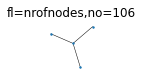

[0, 1, 2, 3]


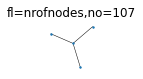

[0, 1, 2, 3]


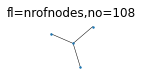

[0, 1, 2, 3]


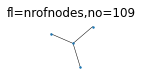

[0, 1, 2, 3]


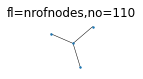

[0, 1, 2, 3]


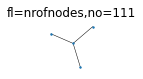

[0, 1, 2, 3]


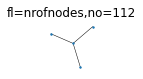

[0, 1, 2, 3]


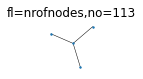

[0, 1, 2, 3]


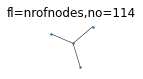

[0, 1, 2, 3]


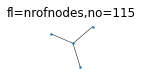

[0, 1, 2, 3]


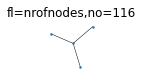

[0, 1, 2, 3]


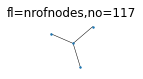

[0, 1, 2, 3]


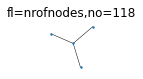

[0, 1, 2, 3]


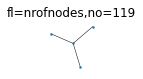

[0, 1, 2, 3]


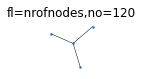

[0, 1, 2, 3]


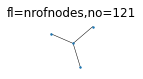

[0, 1, 2, 3]


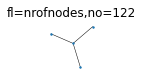

[0, 1, 2, 3]


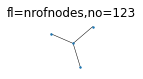

[0, 1, 2, 3]


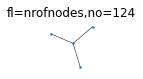

[0, 1, 2, 3]


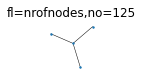

[0, 1, 2, 3]


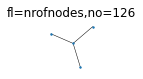

[0, 1, 2, 3]


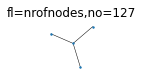

[0, 1, 2, 3]


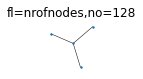

[0, 1, 2, 3]


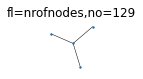

[0, 1, 2, 3]


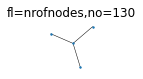

[1, 2, 3]


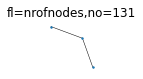

[1, 2, 3]


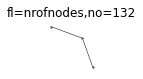

[1, 2, 3]


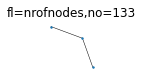

[1, 2, 3]


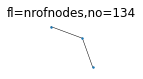

[1, 2, 3]


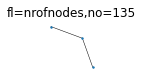

[1, 2, 3]


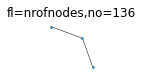

[1, 2, 3]


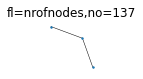

[1, 2, 3]


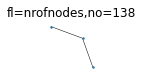

[1, 2, 3]


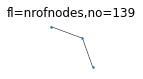

[1, 2, 3]


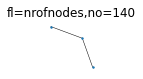

[1, 2, 3]


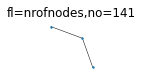

[1, 2, 3]


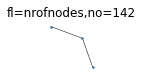

[1, 2, 3]


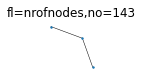

[1, 2, 3]


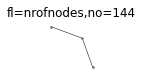

[2, 3]


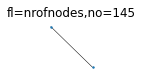

[2, 3]


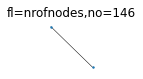

[2, 3]


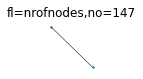

[2, 3]


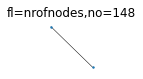

[2, 3]


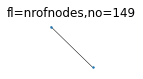

[2, 3]


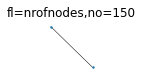

[2, 3]


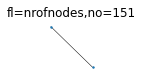

[2, 3]


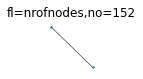

[2, 3]


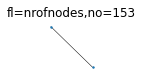

[2, 3]


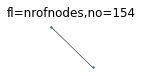

[2, 3]


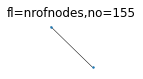

[2, 3]


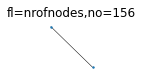

[1, 2, 3]


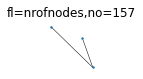

[1, 2, 3]


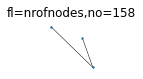

[1, 2, 3]


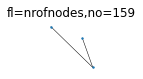

[1, 2, 3]


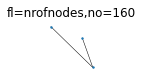

[1, 2, 3]


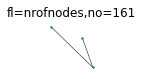

[1, 2, 3]


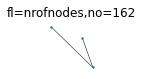

[1, 2, 3]


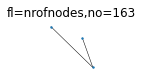

[1, 2, 3]


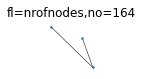

[1, 2, 3]


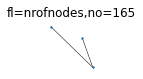

[1, 2, 3]


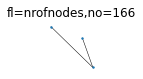

[1, 2, 3]


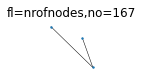

[1, 2, 3]


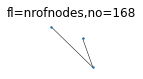

[1, 2, 3]


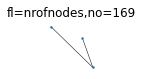

[1, 2, 3]


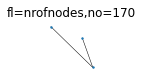

[1, 2, 3]


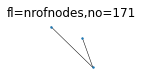

[1, 2, 3]


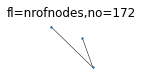

[1, 2, 3]


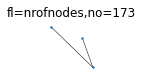

[1, 2, 3]


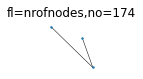

[1, 2, 3]


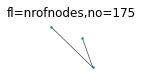

[1, 2, 3]


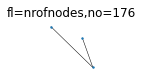

[1, 2, 3]


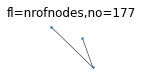

[1, 2, 3]


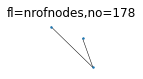

[1, 2, 3]


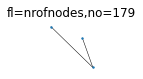

[1, 2, 3]


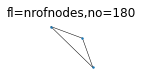

[1, 2, 3]


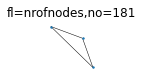

[1, 2, 3]


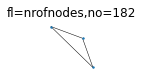

[1, 2, 3]


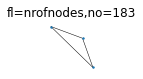

[1, 2, 3]


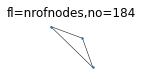

[1, 2, 3]


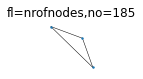

[1, 2, 3]


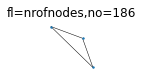

[1, 2, 3]


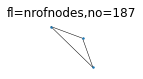

[1, 2, 3]


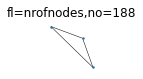

[1, 2, 3]


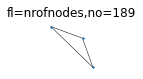

[1, 2, 3]


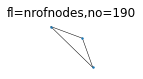

[1, 2, 3]


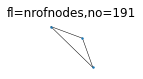

[1, 2, 3]


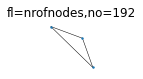

[1, 2, 3]


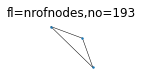

[1, 2, 3]


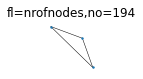

[1, 2, 3]


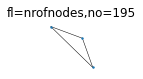

[1, 2, 3]


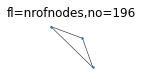

[1, 2, 3]


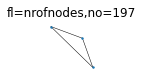

[1, 2, 3]


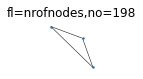

[1, 2, 3]


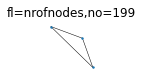

[1, 2, 3]


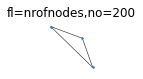

[1, 2, 3]


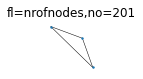

[1, 2, 3]


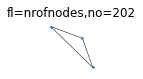

[1, 2, 3]


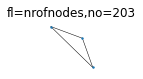

[1, 2, 3]


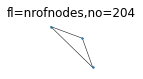

[1, 2, 3]


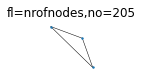

[1, 2, 3]


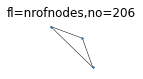

[1, 2, 3]


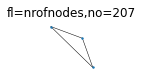

[1, 2, 3]


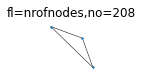

[1, 2, 3]


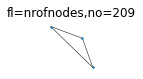

[1, 2, 3]


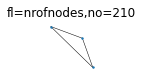

[1, 2, 3]


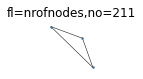

[1, 2, 3]


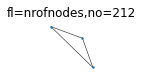

[1, 2, 3]


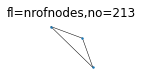

[1, 2, 3]


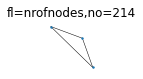

[1, 2, 3]


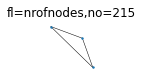

[1, 2, 3]


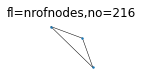

[1, 2, 3]


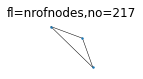

[1, 2, 3]


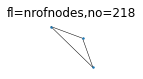

[1, 2, 3]


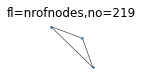

[1, 2, 3]


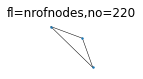

[1, 2, 3]


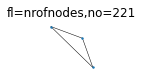

[1, 2, 3]


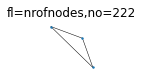

[1, 2, 3]


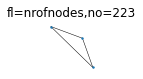

[1, 2, 3]


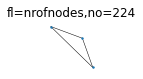

[1, 2, 3]


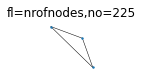

[1, 2, 3]


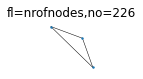

[1, 2, 3]


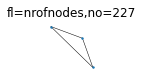

[1, 2, 3]


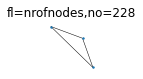

[1, 2, 3]


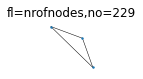

[1, 2, 3]


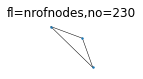

[1, 2, 3]


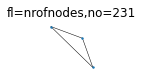

[1, 2, 3]


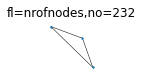

[1, 2, 3]


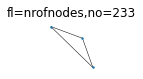

[1, 2, 3]


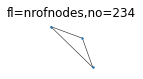

[1, 2, 3]


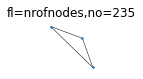

[1, 2, 3]


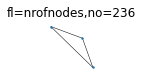

[1, 2, 3]


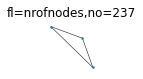

[1, 2, 3]


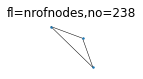

[1, 2, 3]


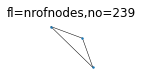

[1, 2, 3]


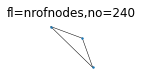

[1, 2, 3]


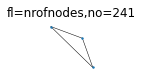

[1, 2, 3]


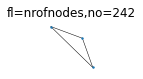

[1, 2, 3]


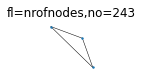

[1, 2, 3]


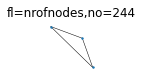

[1, 2, 3]


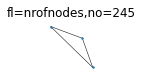

[1, 2, 3]


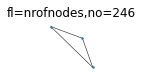

[1, 2, 3]


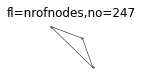

[1, 2, 3]


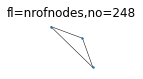

[1, 2, 3]


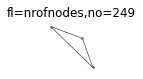

[1, 2, 3]


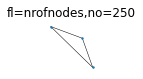

[1, 2, 3]


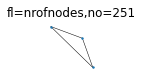

[1, 2, 3]


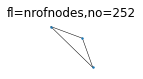

[1, 2, 3]


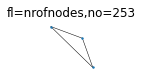

[1, 2, 3]


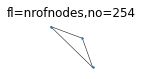

[1, 2, 3]


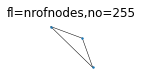

[1, 2, 3]


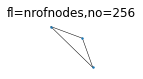

[1, 2, 3]


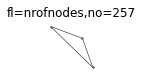

[1, 2, 3]


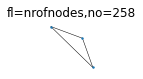

[1, 2, 3]


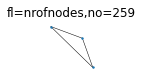

[1, 2, 3]


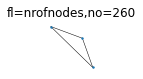

[1, 2, 3]


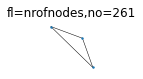

[1, 2, 3]


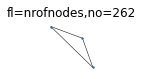

[1, 2, 3]


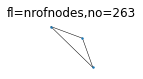

[1, 2, 3]


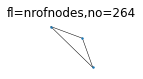

[1, 2, 3]


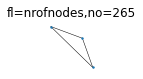

[1, 2, 3]


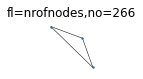

[1, 2, 3]


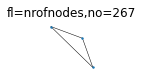

[1, 2, 3]


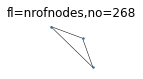

[1, 2, 3]


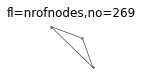

[1, 2, 3]


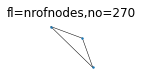

[1, 2, 3]


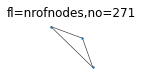

[1, 2, 3]


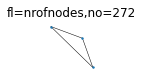

[1, 2, 3]


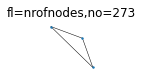

[1, 2, 3]


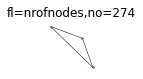

[1, 2, 3]


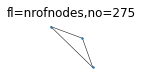

[1, 2, 3]


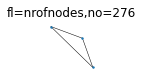

[1, 2, 3]


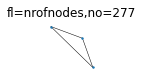

[0, 1, 2, 3]


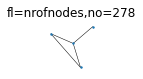

[0, 1, 2, 3]


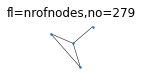

[0, 1, 2, 3]


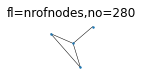

[0, 1, 2, 3]


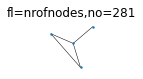

[0, 1, 2, 3]


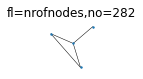

[0, 1, 2, 3]


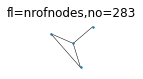

[0, 1, 2, 3]


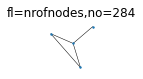

[0, 1, 2, 3]


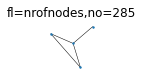

[0, 1, 2, 3]


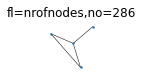

[0, 1, 2, 3]


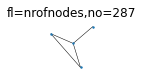

[0, 1, 2, 3]


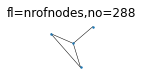

[0, 1, 2, 3]


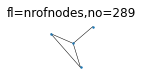

[0, 1, 2, 3]


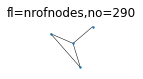

[0, 1, 2, 3]


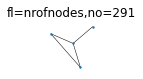

[0, 1, 2, 3]


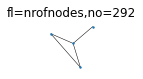

[0, 1, 2, 3]


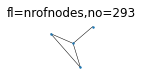

[0, 1, 2, 3]


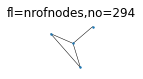

[0, 1, 2, 3]


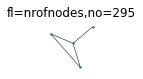

[0, 1, 2, 3]


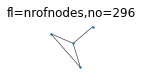

[0, 1, 2, 3]


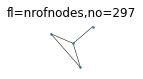

[0, 1, 2, 3]


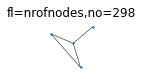

[0, 1, 2, 3]


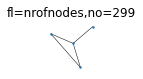

[0, 1, 2, 3]


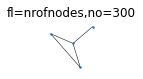

[0, 1, 2, 3]


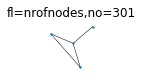

[0, 1, 2, 3]


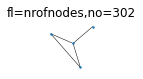

[0, 1, 2, 3]


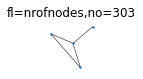

[0, 1, 2, 3]


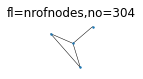

[0, 1, 2, 3]


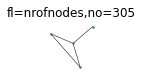

[0, 1, 2, 3]


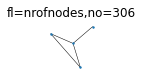

[0, 1, 2, 3]


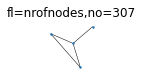

[0, 1, 2, 3]


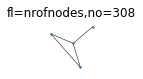

[0, 1, 2, 3]


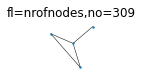

[0, 1, 2, 3]


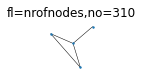

[0, 1, 2, 3]


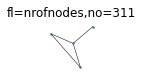

[0, 1, 2, 3]


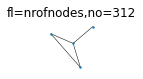

[0, 1, 2, 3]


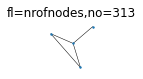

[0, 1, 2, 3]


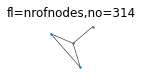

[0, 1, 2, 3]


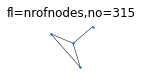

[0, 1, 2, 3]


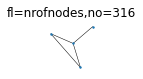

[0, 1, 2, 3]


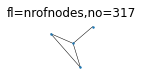

[0, 1, 2, 3]


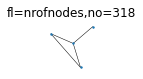

[0, 1, 2, 3]


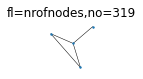

[0, 1, 2, 3]


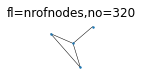

[0, 1, 2, 3]


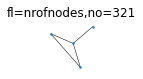

[0, 1, 2, 3]


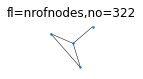

[0, 1, 2, 3]


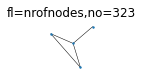

[0, 1, 2, 3]


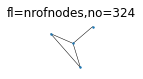

[0, 1, 2, 3]


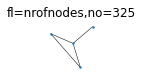

[0, 1, 2, 3]


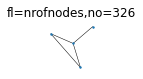

[0, 1, 2, 3]


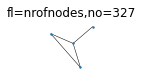

[0, 1, 2, 3]


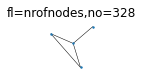

[0, 1, 2, 3]


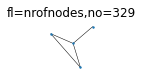

[0, 1, 2, 3]


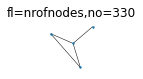

[0, 1, 2, 3]


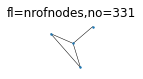

[0, 1, 2, 3]


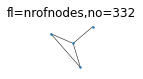

[0, 1, 2, 3]


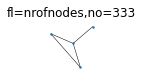

[0, 1, 2, 3]


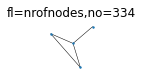

[0, 1, 2, 3]


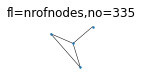

[0, 1, 2, 3]


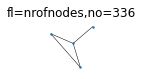

[0, 1, 2, 3]


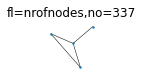

[0, 1, 2, 3]


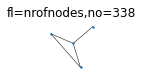

[0, 1, 2, 3]


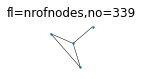

[0, 1, 2, 3]


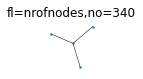

[0, 1, 2, 3]


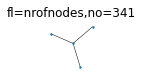

[0, 1, 2, 3]


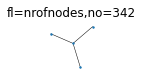

[0, 1, 2, 3]


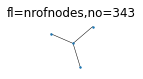

[0, 1, 2, 3]


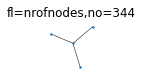

[0, 1, 2, 3]


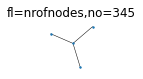

[0, 1, 2, 3]


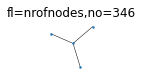

[0, 1, 2, 3]


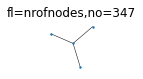

[0, 1, 2, 3]


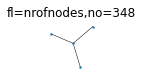

[0, 1, 2, 3]


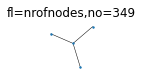

[0, 1, 2, 3]


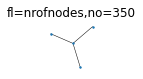

[0, 1, 2, 3]


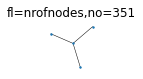

[0, 1, 2, 3]


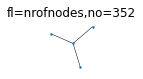

[0, 1, 2, 3]


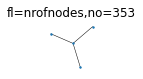

[0, 1, 2, 3]


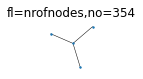

[0, 1, 2, 3]


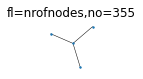

[0, 1, 2, 3]


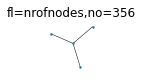

[0, 1, 2, 3]


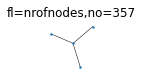

[0, 1, 2, 3]


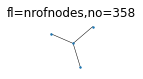

[0, 1, 2, 3]


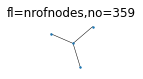

[0, 1, 2, 3]


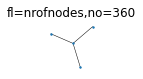

[0, 1, 2, 3]


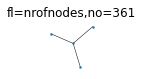

[0, 1, 2, 3]


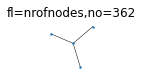

[0, 1, 2, 3]


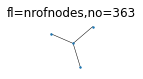

[0, 1, 2, 3]


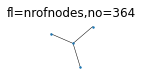

[0, 1, 2, 3]


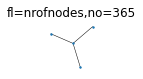

[0, 1, 2, 3]


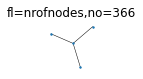

[0, 1, 2, 3]


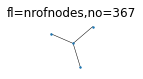

[0, 1, 2, 3]


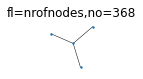

[0, 1, 2, 3]


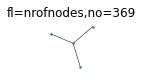

[0, 1, 2, 3]


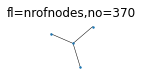

[0, 1, 2, 3]


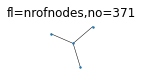

[0, 1, 2, 3]


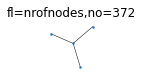

[0, 1, 2, 3]


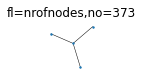

[0, 1, 2, 3]


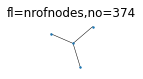

[0, 1, 2, 3]


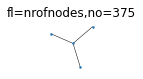

[0, 1, 2, 3]


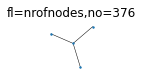

[0, 1, 2, 3]


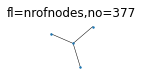

[0, 1, 2, 3]


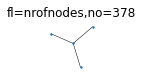

[0, 1, 2, 3]


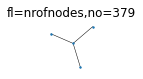

[0, 1, 2, 3]


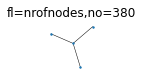

[0, 1, 2, 3]


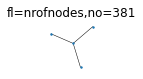

[0, 1, 2, 3]


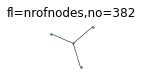

[0, 1, 2, 3]


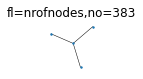

[0, 1, 2, 3]


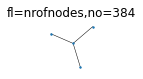

[0, 1, 2, 3]


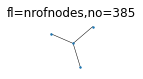

[0, 1, 2, 3]


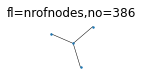

[0, 1, 2, 3]


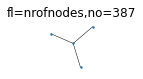

[0, 1, 2, 3]


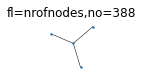

[0, 1, 2, 3]


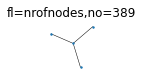

[0, 1, 2, 3]


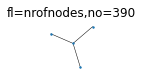

[0, 1, 2, 3]


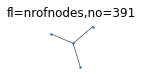

[0, 1, 2, 3]


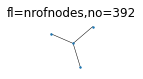

[0, 1, 2, 3]


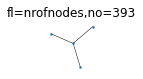

[0, 1, 2, 3]


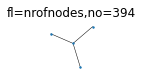

[0, 1, 2, 3]


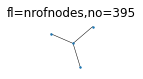

[0, 1, 2, 3]


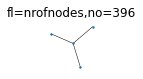

[0, 1, 2, 3]


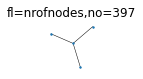

[0, 1, 2, 3]


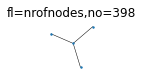

[0, 1, 2, 3]


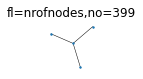

[0, 1, 2, 3]


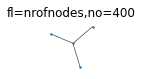

[0, 1, 2, 3]


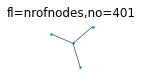

[0, 1, 2, 3]


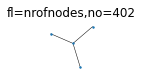

[0, 1, 2, 3]


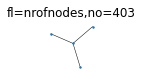

[0, 1, 2, 3]


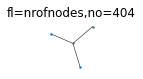

[0, 1, 2, 3]


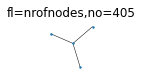

[0, 1, 2, 3]


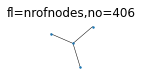

[0, 1, 2, 3]


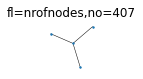

[0, 1, 2, 3]


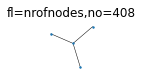

[0, 1, 2, 3]


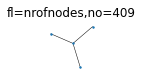

[0, 1, 2, 3]


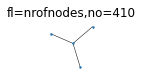

[0, 1, 2, 3]


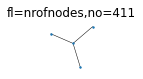

[0, 1, 2, 3]


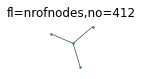

[0, 1, 2, 3]


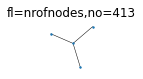

[0, 1, 2, 3]


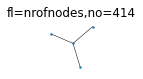

[0, 1, 2, 3]


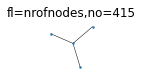

[0, 1, 2, 3]


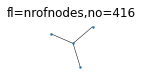

[0, 1, 2, 3]


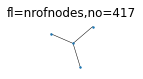

[0, 1, 2, 3]


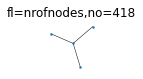

[0, 1, 2, 3]


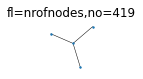

[0, 1, 2, 3]


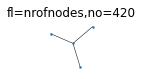

[0, 1, 2, 3]


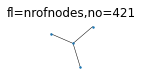

[0, 1, 2, 3]


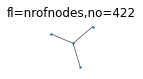

[0, 1, 2, 3]


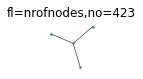

[0, 1, 2, 3]


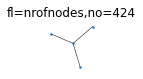

[0, 1, 2, 3]


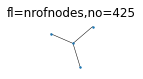

[0, 1, 2, 3]


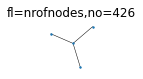

[0, 1, 2, 3]


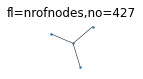

[0, 1, 2, 3]


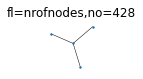

[0, 1, 2, 3]


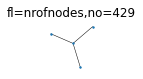

[0, 1, 2, 3]


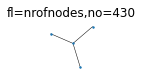

[0, 1, 2, 3]


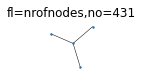

[0, 1, 2, 3]


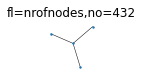

[0, 1, 2, 3]


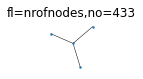

[0, 1, 2, 3]


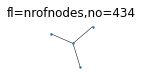

[0, 1, 2, 3]


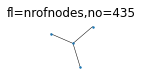

[0, 1, 2, 3]


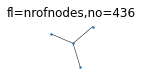

[0, 1, 2, 3]


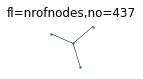

[0, 1, 2, 3]


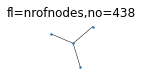

[0, 1, 2, 3]


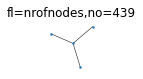

[0, 1, 2, 3]


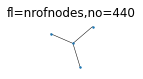

[0, 1, 2, 3]


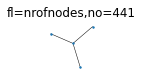

[0, 1, 2, 3]


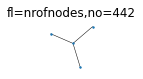

[0, 1, 2, 3]


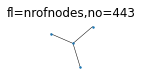

[0, 1, 2, 3]


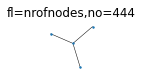

[0, 1, 2, 3]


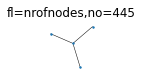

[0, 1, 2, 3]


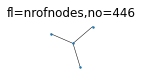

[0, 1, 2, 3]


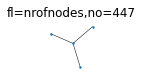

[0, 1, 2, 3]


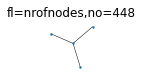

[0, 1, 2, 3]


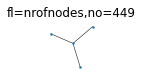

[0, 1, 2, 3]


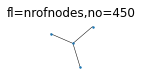

[0, 1, 2, 3]


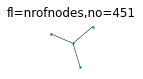

[0, 1, 2, 3]


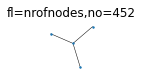

[0, 1, 2, 3]


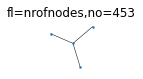

[0, 1, 2, 3]


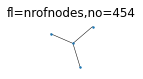

[0, 1, 2, 3]


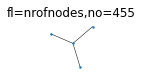

[0, 1, 2, 3]


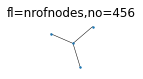

[0, 1, 2, 3]


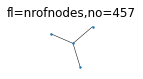

[0, 1, 2, 3]


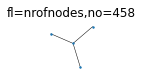

[0, 1, 2, 3]


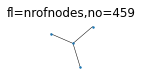

[0, 1, 2, 3]


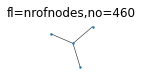

[0, 1, 2, 3]


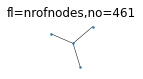

[0, 1, 2, 3]


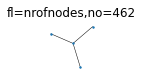

[0, 1, 2, 3]


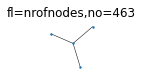

[0, 1, 2, 3]


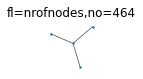

[0, 1, 2, 3]


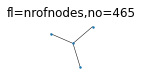

[0, 1, 2, 3]


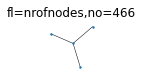

[0, 1, 2, 3]


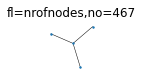

[0, 1, 2, 3]


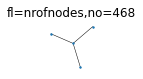

[0, 1, 2, 3]


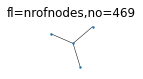

[0, 1, 2, 3]


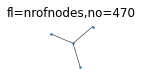

[0, 1, 2, 3]


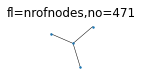

[0, 1, 2, 3]


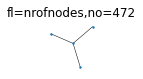

[0, 1, 2, 3]


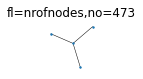

[0, 1, 2, 3]


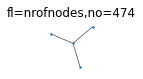

[0, 1, 2, 3]


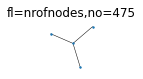

[0, 1, 2, 3]


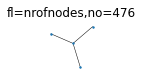

[0, 1, 2, 3]


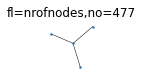

[0, 1, 2, 3]


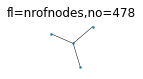

[0, 1, 2, 3]


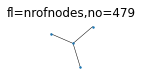

[0, 1, 2, 3]


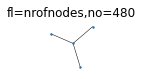

[0, 1, 2, 3]


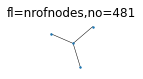

[0, 1, 2, 3]


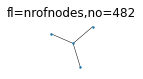

[0, 1, 2, 3]


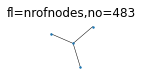

[0, 1, 2, 3]


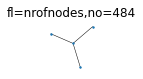

[0, 1, 2, 3]


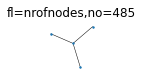

[0, 1, 2, 3]


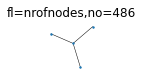

[0, 1, 2, 3]


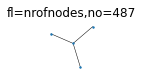

[0, 1, 2, 3]


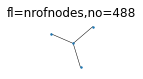

[0, 1, 2, 3]


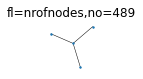

[0, 1, 2, 3]


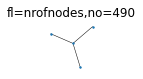

[0, 1, 2, 3]


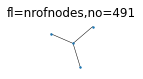

[0, 1, 2, 3]


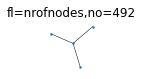

[0, 1, 2, 3]


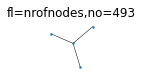

[0, 1, 2, 3]


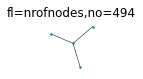

[0, 1, 2, 3]


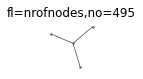

[0, 1, 2, 3]


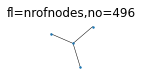

[0, 1, 2, 3]


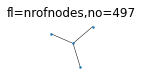

[0, 1, 2, 3]


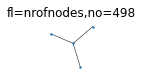

[0, 1, 2, 3]


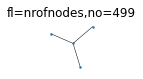

[0, 1, 2, 3]


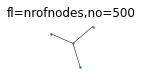

[0, 1, 2, 3]


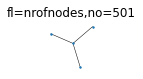

[0, 1, 2, 3]


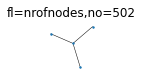

[0, 1, 2, 3]


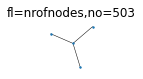

[0, 1, 2, 3]


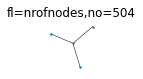

[0, 1, 2, 3]


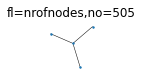

[0, 1, 2, 3]


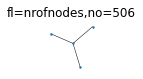

[0, 1, 2, 3]


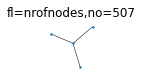

[0, 1, 2, 3]


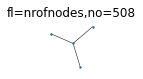

[0, 1, 2, 3]


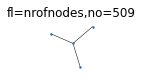

[0, 1, 2, 3]


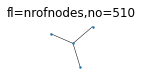

[0, 1, 2, 3]


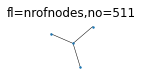

[0, 1, 2, 3]


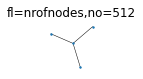

40 32
Time computing degree mmd:  0:00:00.582883
{'degree': 0.05014227078176814}
Time computing clustering mmd:  0:00:03.557839
{'degree': 0.05014227078176814, 'cluster': 0.0778943473378747}
{'degree': 0.05014227078176814, 'cluster': 0.0778943473378747, 'orbit': 0.0}


In [14]:
from argparse import Namespace
import networkx as nx
import sys
from utils.graph_utils import discretenoise, generate_mask, discretenoise_balanced_single, discretenoise_balanced, discretenoise_single_density


#args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_8.5_14:49/gridsearch_ppgn_consec_trees_60_200_pkl_6,16_7_32.yaml', log_level='INFO', comment='')
args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_15.5_17:51/gridsearch_ppgn_consec_ego_18_small_6,32_5_32_density_True.yaml', log_level='INFO', comment='')
#args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_ppgn_16.5_21:37/gridsearch_ppgn_consec_sbm_27_200_pkl_6,32_5_32_density_True.yaml', log_level='INFO', comment='')


ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)
#
(config_dict)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-05-01-52-51_19452/models/best",1,16)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-05-01-52-52_6702/models",1,100)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-08-14-50-33_10454/models",1,10)
#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-08-19-38-45_12711/models",1,16)

#sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-10-14-22-20_12504/models",1,12)
enablePrint()
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-15-17-51-42_4432/models",1,12)
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-15-17-51-42_12636/models",1,10)


#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-16-10-53-22_29189/models",1,8)
#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-16-10-53-21_19805/models",1,4)


#a=sample_main_bala(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-17-13-59-41_24299/models",1,12)
#a=sample_main_bala(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-17-13-59-41_2595/models",1,32)

#a=sample_main_density(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_trees_60_200_pkl__May-16-22-32-58_18486/models",1,16)



#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-28-15-30-20_9893/models",1,32)

#a=sample_main(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-24-00-15-02_16543/models/best",1,1000)

##kld with sbm
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-28-22-48-41_20431/models",1,128)
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-28-22-48-58_4319/models",1,32)
#a=sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_sbm_27_200_pkl__May-29-15-52-32_30248/models",1,32)




##this is to test a good new ego and its best
best=[]
bestloss=[]
for i in range(1,2):
    a = sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-29-22-01-51_19027/models/best",1,512)
    b = sample_main_new(config_dict,"/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/ppgn_ego_18_small__May-30-15-18-14_10869/models/bestloss",1,512)
    best.append(a)
    bestloss.append(b)
    print(b)







In [21]:
bestloss

[{'degree': 0.01896070191713184, 'cluster': 0.02987721231199969, 'orbit': 0.0},
 {'degree': 0.06071166411988571, 'cluster': 0.08231472567028209, 'orbit': 0.0},
 {'degree': 0.11484592859690235, 'cluster': 0.16041882718229517, 'orbit': 0.0},
 {'degree': 0.03658603916819425,
  'cluster': 0.054613234173278125,
  'orbit': 0.0},
 {'degree': 0.0699195419666494, 'cluster': 0.08224981433726497, 'orbit': 0.0}]

In [10]:
bestloss

[{'degree': 0.03466617222736801, 'cluster': 0.07005079516278628, 'orbit': 0.0}]

In [15]:
best

[{'degree': 0.02930551555829708,
  'cluster': 0.028594642485752164,
  'orbit': 0.0}]

In [16]:
bestloss

[{'degree': 0.05014227078176814, 'cluster': 0.0778943473378747, 'orbit': 0.0}]

In [13]:
import logging
import pickle
import os

from easydict import EasyDict as edict
import numpy as np
import torch

from evaluation.stats import eval_torch_batch, adjs_to_graphs, eval_graph_list, eval_acc_sbm_graph
from utils.arg_helper import mkdir, set_seed_and_logger, load_data, graphs_to_tensor, load_model, parse_arguments, \
    get_config
from utils.graph_utils import discretenoise
from utils.loading_utils import get_mc_sampler, eval_sample_batch, prepare_test_model, prepare_test_model_train
from utils.visual_utils import plot_graphs_list, plot_inter_graphs, plot_inter_graphs_list



def posterior(sigmatilde_t,sigma_t,sigmatilde_t1,x0,xt):
    if xt<0.01 and x0<0.01:
        return sigmatilde_t1 * sigma_t / (1-sigmatilde_t)
    elif xt>0.99 and x0<0.01:
        return sigmatilde_t1 * (1-sigma_t) / (sigmatilde_t)
    elif xt>0.99 and x0>0.99:
        return (1-sigmatilde_t1) * (1-sigma_t) / (1-sigmatilde_t)
    if xt<0.01 and x0>0.99:
        return (1-sigmatilde_t1) * sigma_t / (sigmatilde_t)



def sigma_lin_false(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if i<0.0000000001:
            sigmas.append(0.0)
        summ=0.0
        for k,sigpast in enumerate(sigmas):
            prod=1.0
            for j in range(0,g-1-k):
                prod = prod * ( 1 - 2 * sigmas[g-k] )
            prod = prod * sigmas[k]
        summ+=prod
        s=sigma-summ
        sigmas.append(s)

def sigma_lin(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if sigma<0.0000000001:
            sigmas.append(0.0)
            continue
        sigmas.append(((1-sigma)-(1-sigma_list[g-1]))/(1-2*(1-sigma_list[g-1])))
    return sigmas

def sample_main_edp(config, modellink,epoch,noise_num):
    
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = 32
    ###optional lines here only to be used if we want to logg the progress
    #mult_stages = []

    ##initial batch will be chosen from complete noise as it the forward noise process should in theory always arrive at a completely random distribution if sampled enough times
    def gen_init_data(batch_size):
        ##chose randomly among traindata on how many nodes should be used and on how they are ordered
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
        
        """bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if col>1/2:
                            bernoulli_adj[k,i,j] = 1/2"""

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        #### doesnt have to get masked as it only has nonzero probability where nodeflags are not zero for both nodes
        

        """##generate base embedding based on degree of node
        base_x = node_flags
        for k, matrix in enumerate(node_flags):
            for i, x  in enumerate(matrix):
                base_x = torch.sum(initialmatrix[k,i])"""

        ##this line is to simply assert that all attributes are initialized with zero
        #base_x = base_x.gt(1e-5).to(dtype=torch.float32)
        base_x=torch.zeros_like(base_x)
        return initialmatrix, base_x, node_flags


    ##load model and sigma configuration
    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,len(config.train.sigmas))
    ##so now the 0 must be taken out
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()



    


    def take_step(noise_func, init_flags, init_adjs,sigma_list):
        ##input is x matrices each with a certain level of noise corrsp to sigma_list[1:]


        sigma_zeros=torch.zeros(init_adjs.size(0))
        sigma_zeros_nontild=torch.zeros(init_adjs.size(0))
        sigma_zeros_ind=torch.zeros(init_adjs.size(0))

        sigma_ind_list = range(1,len(sigma_list))
        sig_list = sigma_lin(np.linspace(0,1/2,len(sigma_list)).tolist())
        sigma_nontild_list = [sig_list[i] for i in sigma_ind_list]

        count=0
        for j in sigma_ind_list:
            for i in range(int(init_adjs.size(0)/(len(sigma_list)-1))):
                sigma_zeros[count]=sigma_list[j]
                sigma_zeros_nontild[count]=sig_list[j]
                ##now we say which index belongs to each element
                sigma_zeros_ind[count]=j
                count=count+1
        
        sigma_list=sigma_zeros.to(config.dev)
        sigma_nontild_list=sigma_zeros_nontild.to(config.dev)
        sigma_ind_list=sigma_zeros_ind.to(config.dev)

        noise_unnormal = noise_func(init_adjs, init_flags)
        ##apply sigmoid since we must normalize this first and then go to 0 or 1 abolute values
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here we take the absolute value of the noise predictions

        for i,adj in enumerate(init_adjs):
            sigmatilde_t=sigma_list[i]
            sigma_t=sigma_nontild_list[i]
            sigmatilde_t1=sigma_list[i]-sigma_list[i]/sigma_ind_list[i]
            score_i=torch.where(init_adjs[i]>1/2,1-noise_rel[i],noise_rel[i])

            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.zeros_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.zeros_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p = ( 1 - score_i ) * mult1*mult2/div

            ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.ones_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.ones_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p += ( score_i ) * mult1 * mult2/div
            noise_rel[i] = (p + p.transpose(-2,-1))/2
        
        noise_rel = torch.bernoulli(noise_rel).to(config.dev)
        noise_rel = torch.triu(noise_rel,diagonal=1) + torch.triu(noise_rel,diagonal=1).transpose(-2,-1)

        return noise_rel.chunk(len(sigma_list)-1, dim=0)


    ##loop through each noise level from high noise to low level noise and at each step add 
    ## i use a very poor approach here since i use the edp layer i compute the model way too many times which makes this very inefficient. could be solved by being able to let model run on single sigma instead of everytime on everything
    def run_sample(eval_len=1024, methods=None):
        warm_up_count = 0
        gen_graph_list = []
        #print(test_batch_size)

        ######create list in len-1 since dont include the last sigma 0
        init_adjs, init_x, node_flags = gen_init_data(batch_size = test_batch_size * (len(sigma_list)-1))

        
        #torch.set_printoptions(profile="full")
        #print("wwwww")
        #print(init_adjs)
        #print(init_x)
        #print(node_flags)
        #print("wwwww")
        
        sample_node_flags=node_flags
        sample_adjs=init_adjs
        sample_x=init_x

        #mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]
        #mult_stages.append(adjs_to_graphs(sample_adjs.chunk(len(sigma_list), dim=0)[-1].detach().cpu().numpy()))

        ######chunck in len-1 since dont include sigma = 0
        mult_stages = [adjs_to_graphs(sample_adjs.chunk(len(sigma_list)-1,dim=0)[-1].detach().cpu().numpy())]

        assert(eval_len>=len(sigma_list)-1)

        while len(gen_graph_list) < eval_len:

            ##disable gradient since we never call .backward() here
            with torch.no_grad():
                ##how does the model deal with batch sizes different in training and sampling??? makes no sense if sigma is no input and batch sizes can be of different sizes
                sample_adjs_list = take_step(lambda x, y: model(sample_x, x, y), init_flags=sample_node_flags, init_adjs=sample_adjs,sigma_list=sigma_list)
                ##now all adjs have been updated with their respective sigmoid level and returned as a LIST of tensors each list element corresp to 1 sigmoid level
                
                ####i think there is an error in original paper here has to be >=-1 instead of >=, but if u want to go sure then do >=
                if warm_up_count >= len(sigma_list)-2:
                    ####not sure why in original sampling they only take zeroth element of batch?? here we add all elements of a list of finished matrices (= 1 signoidlevelbatch)
                    gen_graph_list.extend(adjs_to_graphs(sample_adjs_list[0].detach().cpu().numpy()))
                    warm_up_count += 1
                else:
                    warm_up_count += 1
                
                ###########logs the first batch that fully runs through all sigmalevels and saves it at every level to mult_stages list
                if True:
                        """
                        if warm_up_count==1:
                            mult_stages = [adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy())]
                            #mult_stages.append(adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy()))
                            mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]"""
                        
                ############
                
                ##now we remove the sigmoidbatch that we just added or wasnt ready and has to be discarded and add a random adjs at end so that we can further iterate and generate samples
                new_sample_adjs, new_sample_x, new_node_flags = gen_init_data(batch_size=test_batch_size)
                sample_adjs = torch.cat(list(sample_adjs_list[1:]) + [new_sample_adjs], dim=0)
                ####not sure how this converts tensor to tensor and how, probably just adds the new embeddings at end
                sample_x = torch.cat([sample_x[sample_adjs_list[0].size(0):], new_sample_x], dim=0)
                sample_node_flags = torch.cat([sample_node_flags[sample_adjs_list[0].size(0):], new_node_flags], dim=0)

        ##now left with a list of genereated graphs, namely gen_graph_list only left is to plot and evaluate
        
        #### not sure if these functions work since i had trouble with them maybe have to self implement these
        
        ###print the intermediate graphs

        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        return result_dict, gen_graph_list


    results, gen_graph_list = run_sample(eval_len=1024)
    ##this is also copied from original so not sure if works to dump pickle data
    return results

def sample_testing_edp(config, modellink,epoch,noise_num,train_dl):
    
    train_graph_list_adj=[]
    train_graph_list_x=[]
    train_graph_list=[]
    for train_adj_b, train_x_b in train_dl:
        print("asasasasasa")
        print(train_adj_b)
        for adj, x  in zip(train_adj_b, train_x_b):
            print("bgbgbgbgbgb")
            print(adj)
            train_graph_list_adj.append(adj.clone().detach())
            train_graph_list_x.append(x.clone().detach())
        train_graph_list.extend(adjs_to_graphs(train_adj_b.detach().cpu().numpy()))
    print(train_graph_list_adj)
    
    train_graph_list_adj=torch.stack(train_graph_list_adj)
    train_graph_list_x=torch.stack(train_graph_list_x)
    #mcmc_sampler = get_mc_sampler(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = 4
    ###optional lines here only to be used if we want to logg the progress
    #mult_stages = []

    ##initial batch will be chosen from complete noise as it the forward noise process should in theory always arrive at a completely random distribution if sampled enough times
    def gen_init_data(batch_size):
        ##chose randomly among traindata on how many nodes should be used and on how they are ordered
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        #graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = [train_graph_list_adj[i] for i in rand_idx], [train_graph_list_x[i] for i in rand_idx]
        base_adjs, base_x = torch.stack(base_adjs), torch.stack(base_x)
        #base_adjs, base_x = train_graph_list_adj, train_graph_list_x
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
        
        """bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if col>1/2:
                            bernoulli_adj[k,i,j] = 1/2"""

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        #### doesnt have to get masked as it only has nonzero probability where nodeflags are not zero for both nodes
        

        """##generate base embedding based on degree of node
        base_x = node_flags
        for k, matrix in enumerate(node_flags):
            for i, x  in enumerate(matrix):
                base_x = torch.sum(initialmatrix[k,i])"""

        ##this line is to simply assert that all attributes are initialized with zero
        #base_x = base_x.gt(1e-5).to(dtype=torch.float32)
        base_x=torch.zeros_like(base_x)
        return initialmatrix, base_x, node_flags


    ##load model and sigma configuration
    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,len(config.train.sigmas))
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()


    def take_step(noise_func, init_flags, init_adjs,sigma_list):
        ##input is x matrices each with a certain level of noise corrsp to sigma_list[1:]


        sigma_zeros=torch.zeros(init_adjs.size(0))
        sigma_zeros_nontild=torch.zeros(init_adjs.size(0))
        sigma_zeros_ind=torch.zeros(init_adjs.size(0))
        
        sigma_ind_list = range(1,len(sigma_list))
        sig_list = sigma_lin(np.linspace(0,1/2,len(sigma_list)).tolist())
        sigma_nontild_list = [sig_list[i] for i in sigma_ind_list]

        count=0
        for j in sigma_ind_list:
            for i in range(int(init_adjs.size(0)/(len(sigma_list)-1))):
                sigma_zeros[count]=sigma_list[j]
                sigma_zeros_nontild[count]=sig_list[j]
                ##now we say which index belongs to each element
                sigma_zeros_ind[count]=j
                count=count+1
        ##removed two and added 32
        sigma_list_2=sigma_zeros.to(config.dev)
        sigma_nontild_list=sigma_zeros_nontild.to(config.dev)
        sigma_ind_list=sigma_zeros_ind.to(config.dev)
        print("noisefuncstart")
        print(init_adjs)
        ##init adjs is size batch*sigmas x n x n 
        try:
            print(init_adjs.size())
        except:
            print(len(init_adjs))
        noise_unnormal = noise_func(init_adjs, init_flags)
        ##apply sigmoid since we must normalize this first and then go to 0 or 1 abolute values
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here we take the absolute value of the noise predictions

        for i,adj in enumerate(init_adjs):
            sigmatilde_t=sigma_list_2[i]
            sigma_t=sigma_nontild_list[i]
            sigmatilde_t1=sigma_list_2[i]-sigma_list_2[i]/sigma_ind_list[i]
            score_i=torch.where(init_adjs[i]>1/2,1-noise_rel[i],noise_rel[i])

            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.zeros_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.zeros_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p = ( 1 - score_i ) * mult1*mult2/div

            ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.ones_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.ones_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p += ( score_i ) * mult1 * mult2/div
            noise_rel[i] = (p + p.transpose(-2,-1))/2
        
        noise_rel = torch.bernoulli(noise_rel).to(config.dev)
        noise_rel = torch.triu(noise_rel,diagonal=1) + torch.triu(noise_rel,diagonal=1).transpose(-2,-1)
        print(noise_rel)
        
        print(noise_rel.chunk(len(sigma_list)-1, dim=0))
        print("noiserelchunk")
        return noise_rel.chunk(len(sigma_list)-1, dim=0)


    ##loop through each noise level from high noise to low level noise and at each step add 
    ## i use a very poor approach here since i use the edp layer i compute the model way too many times which makes this very inefficient. could be solved by being able to let model run on single sigma instead of everytime on everything
    def run_sample(eval_len=1024, methods=None):
        warm_up_count = 0
        gen_graph_list = []
        #print(test_batch_size)
        init_adjs, init_x, node_flags = gen_init_data(batch_size = test_batch_size * (len(sigma_list)-1))
        #torch.set_printoptions(profile="full")
        #print("wwwww")
        #print(init_adjs)
        #print(init_x)
        #print(node_flags)
        #print("wwwww")
        
        sample_node_flags=node_flags
        sample_adjs=init_adjs
        sample_x=init_x

        #mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]
        #mult_stages.append(adjs_to_graphs(sample_adjs.chunk(len(sigma_list), dim=0)[-1].detach().cpu().numpy()))
        mult_stages = [adjs_to_graphs(sample_adjs.chunk(len(sigma_list)-1,dim=0)[-1].detach().cpu().numpy())]

        assert(eval_len>=len(sigma_list))

        while len(gen_graph_list) < eval_len:

            ##disable gradient since we never call .backward() here
            with torch.no_grad():
                ##how does the model deal with batch sizes different in training and sampling??? makes no sense if sigma is no input and batch sizes can be of different sizes
                
                sample_adjs_list = take_step(lambda x, y: model(sample_x, x, y), init_flags=sample_node_flags, init_adjs=sample_adjs,sigma_list=sigma_list)
                ##now all adjs have been updated with their respective sigmoid level and returned as a LIST of tensors each list element corresp to 1 sigmoid level
                
                ####i think there is an error in original paper here has to be >=-1 instead of >=, but if u want to go sure then do >=
                if warm_up_count >= len(sigma_list)-2:
                    ####not sure why in original sampling they only take zeroth element of batch?? here we add all elements of a list of finished matrices (= 1 signoidlevelbatch)
                    gen_graph_list.extend(adjs_to_graphs(sample_adjs_list[0].detach().cpu().numpy()))
                    warm_up_count += 1
                else:
                    warm_up_count += 1
                
                ###########logs the first batch that fully runs through all sigmalevels and saves it at every level to mult_stages list
                if True:
                        """
                        if warm_up_count==1:
                            mult_stages = [adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy())]
                            #mult_stages.append(adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy()))
                            mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]"""
                        
                ############
                
                ##now we remove the sigmoidbatch that we just added or wasnt ready and has to be discarded and add a random adjs at end so that we can further iterate and generate samples
                new_sample_adjs, new_sample_x, new_node_flags = gen_init_data(batch_size=test_batch_size)
                sample_adjs = torch.cat(list(sample_adjs_list[1:]) + [new_sample_adjs], dim=0)
                ####not sure how this converts tensor to tensor and how, probably just adds the new embeddings at end
                sample_x = torch.cat([sample_x[sample_adjs_list[0].size(0):], new_sample_x], dim=0)
                sample_node_flags = torch.cat([sample_node_flags[sample_adjs_list[0].size(0):], new_node_flags], dim=0)

        ##now left with a list of genereated graphs, namely gen_graph_list only left is to plot and evaluate
        
        #### not sure if these functions work since i had trouble with them maybe have to self implement these
        
        ###print the intermediate graphs

        result_dict = eval_graph_list(train_graph_list, gen_graph_list, methods=methods)
        logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        pic_title = f'{file.split("/")[-1]}_final_sample_{epoch}_{noise_num}.pdf'
        plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        print(len(gen_graph_list))
        print("lengthresultlist")
        return result_dict, gen_graph_list


    results, gen_graph_list = run_sample(eval_len=128)
    ##this is also copied from original so not sure if works to dump pickle data
    return results




        


In [9]:
from argparse import Namespace
import networkx as nx
import sys
from utils.graph_utils import discretenoise, generate_mask, discretenoise_balanced_single, discretenoise_balanced, discretenoise_single_density
from utils.graph_utils import mask_adjs

args = Namespace(config_file='/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/config/gridsearch/consec_edp_2.6_11:29/gridsearch_edp_consec_ego_18_small_6,32_1_32_switched_True_1234.yaml', log_level='INFO', comment='')


ori_config_dict = get_config(args)
config_dict = edict(ori_config_dict.copy())
process_config(config_dict)



sample_main_edp(config_dict, "/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/edp-gnn_ego_18_small__Jun-02-11-30-02_8998/models", 1, 5)


3
2
3
[Errno 21] Is a directory: '/scratch/snx3000/khaefeli/khaefeli_graph_ddpm/GraphScoreMatching_ddpm_discrete/GraphScoreMatching_ppgn/exp/gridsearch/edp-gnn_ego_18_small__Jun-02-11-30-02_8998/models/best'
22
20 64
Time computing degree mmd:  0:00:00.731556
{'degree': 0.15163800636122193}
Time computing clustering mmd:  0:00:05.179867
{'degree': 0.15163800636122193, 'cluster': 0.32224491773103414}
-------------------------
[ 2.62151376  5.22563131  2.61281566  1.89617383  0.96738928  0.96738928
 10.18404804  3.39468268  1.55833333  1.74112554  3.48225108  1.74112554
  2.11330669  2.11330669  0.66242424]
...
[1.49337798 1.39255952 0.69627976 0.328125   0.         0.
 1.20334821 0.40111607 0.         0.0359375  0.071875   0.0359375
 0.0734375  0.0734375  0.015625  ]
-------------------------
{'degree': 0.15163800636122193, 'cluster': 0.32224491773103414, 'orbit': 0.06533554405989861}


{'degree': 0.15163800636122193,
 'cluster': 0.32224491773103414,
 'orbit': 0.06533554405989861}

In [8]:
def sample_main_edp(config, modellink,epoch,noise_num):
    
    train_graph_list, test_graph_list = load_data(config, get_graph_list=True)
    #mcmc_sampler = get_mc_sampler(config)
    models = prepare_test_model_train(config,modellink)
    max_node_number = config.dataset.max_node_num
    test_batch_size = config.test.batch_size
    ###optional lines here only to be used if we want to logg the progress
    #mult_stages = []

    ##initial batch will be chosen from complete noise as it the forward noise process should in theory always arrive at a completely random distribution if sampled enough times
    def gen_init_data(batch_size):
        ##chose randomly among traindata on how many nodes should be used and on how they are ordered
        rand_idx = np.random.randint(0, len(train_graph_list), batch_size)
        graph_list = [train_graph_list[i] for i in rand_idx]
        base_adjs, base_x = graphs_to_tensor(config, graph_list)
        base_adjs, base_x = base_adjs.to(config.dev), base_x.to(config.dev)
        node_flags = base_adjs.sum(-1).gt(1e-5).to(dtype=torch.float32)

        #node_flags=torch.ones_like(node_flags)
        
        ##create a matrix with p=1/2 elements at all positions Aij where i and j not masked by node_flagij=0:
        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if 1/2 < node_flags[k][i] and 1/2 < node_flags[k][j]:
                            bernoulli_adj[k,i,j] = 1/2
        
        """bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(config.dev)
        for k, matrix in enumerate(base_adjs):
            for i,row in enumerate(matrix):
                    for j,col in enumerate(row):
                        if col>1/2:
                            bernoulli_adj[k,i,j] = 1/2"""

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        #### doesnt have to get masked as it only has nonzero probability where nodeflags are not zero for both nodes
        

        """##generate base embedding based on degree of node
        base_x = node_flags
        for k, matrix in enumerate(node_flags):
            for i, x  in enumerate(matrix):
                base_x = torch.sum(initialmatrix[k,i])"""

        ##this line is to simply assert that all attributes are initialized with zero
        #base_x = base_x.gt(1e-5).to(dtype=torch.float32)
        base_x=torch.zeros_like(base_x)
        return initialmatrix, base_x, node_flags


    ##load model and sigma configuration
    file, sigma_list, model_params = models[0]
    model = load_model(*model_params)
    sigma_tens = torch.linspace(0,1/2,len(config.train.sigmas))
    ##so now the 0 must be taken out
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()



    


    def take_step(noise_func, init_flags, init_adjs,sigma_list):
        ##input is x matrices each with a certain level of noise corrsp to sigma_list[1:]


        sigma_zeros=torch.zeros(init_adjs.size(0))
        sigma_zeros_nontild=torch.zeros(init_adjs.size(0))
        sigma_zeros_ind=torch.zeros(init_adjs.size(0))

        sigma_ind_list = range(1,len(sigma_list))
        sig_list = sigma_lin(np.linspace(0,1/2,len(sigma_list)).tolist())
        sigma_nontild_list = [sig_list[i] for i in sigma_ind_list]

        count=0
        for j in sigma_ind_list:
            for i in range(int(init_adjs.size(0)/(len(sigma_list)-1))):
                sigma_zeros[count]=sigma_list[j]
                sigma_zeros_nontild[count]=sig_list[j]
                ##now we say which index belongs to each element
                sigma_zeros_ind[count]=j
                count=count+1
        
        sigma_list=sigma_zeros.to(config.dev)
        sigma_nontild_list=sigma_zeros_nontild.to(config.dev)
        sigma_ind_list=sigma_zeros_ind.to(config.dev)

        noise_unnormal = noise_func(init_adjs, init_flags)
        ##apply sigmoid since we must normalize this first and then go to 0 or 1 abolute values
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here we take the absolute value of the noise predictions

        for i,adj in enumerate(init_adjs):
            sigmatilde_t=sigma_list[i]
            sigma_t=sigma_nontild_list[i]
            sigmatilde_t1=sigma_list[i]-sigma_list[i]/sigma_ind_list[i]
            score_i=torch.where(init_adjs[i]>1/2,1-noise_rel[i],noise_rel[i])

            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.zeros_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.zeros_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p = ( 1 - score_i ) * mult1*mult2/div

            ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
            mult1=torch.where(init_adjs[i]>1/2,(1-sigma_t),sigma_t)
            mult2=torch.where(torch.ones_like(init_adjs[i])>1/2,1-sigmatilde_t1,sigmatilde_t1)
            xor=torch.logical_xor(init_adjs[i], torch.ones_like(init_adjs[i]))
            div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
            p += ( score_i ) * mult1 * mult2/div

            p=mask_adjs(p,init_flags[ int(init_adjs.size(0)/sigma_ind_list[-1])])

            noise_rel[i] = (p + p.transpose(-2,-1))/2

        #noise_rel=torch.where(noise_rel>1/2,1.0,0.0)
        
        
        noise_rel = torch.bernoulli(noise_rel).to(config.dev)
        
        ##noise_rel=
        
        noise_rel = torch.triu(noise_rel,diagonal=1) + torch.triu(noise_rel,diagonal=1).transpose(-2,-1)
        

        return noise_rel.chunk(len(sigma_list)-1, dim=0)


    ##loop through each noise level from high noise to low level noise and at each step add 
    ## i use a very poor approach here since i use the edp layer i compute the model way too many times which makes this very inefficient. could be solved by being able to let model run on single sigma instead of everytime on everything
    def run_sample(eval_len=1024, methods=None):
        warm_up_count = 0
        gen_graph_list = []
        #print(test_batch_size)

        ######create list in len-1 since dont include the last sigma 0
        init_adjs, init_x, node_flags = gen_init_data(batch_size = test_batch_size * (len(sigma_list)-1))

        
        #torch.set_printoptions(profile="full")
        #print("wwwww")
        #print(init_adjs)
        #print(init_x)
        #print(node_flags)
        #print("wwwww")
        
        sample_node_flags=node_flags
        sample_adjs=init_adjs
        sample_x=init_x

        mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]
        #mult_stages.append(adjs_to_graphs(sample_adjs.chunk(len(sigma_list)-1, dim=0)[-1].detach().cpu().numpy()))

        ######chunck in len-1 since dont include sigma = 0
        mult_stages = [adjs_to_graphs(sample_adjs.chunk(len(sigma_list)-1,dim=0)[-1].detach().cpu().numpy())]

        assert(eval_len>=len(sigma_list)-1)

        while len(gen_graph_list) < eval_len:

            ##disable gradient since we never call .backward() here
            with torch.no_grad():
                ##how does the model deal with batch sizes different in training and sampling??? makes no sense if sigma is no input and batch sizes can be of different sizes
                sample_adjs_list = take_step(lambda x, y: model(sample_x, x, y), init_flags=sample_node_flags, init_adjs=sample_adjs,sigma_list=sigma_list)
                ##now all adjs have been updated with their respective sigmoid level and returned as a LIST of tensors each list element corresp to 1 sigmoid level
                
                ####i think there is an error in original paper here has to be >=-1 instead of >=, but if u want to go sure then do >=
                if warm_up_count >= len(sigma_list)-2:
                    ####not sure why in original sampling they only take zeroth element of batch?? here we add all elements of a list of finished matrices (= 1 signoidlevelbatch)
                    gen_graph_list.extend(adjs_to_graphs(sample_adjs_list[0].detach().cpu().numpy()))
                    warm_up_count += 1
                else:
                    warm_up_count += 1
                
                ###########logs the first batch that fully runs through all sigmalevels and saves it at every level to mult_stages list
                if True:
                        
                        if warm_up_count==1:
                            mult_stages = [adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy())]
                            #mult_stages.append(adjs_to_graphs(sample_adjs_list[-warm_up_count].detach().cpu().numpy()))
                            mult_stages_flags = sample_node_flags[-test_batch_size*(warm_up_count): len(sample_node_flags)-(test_batch_size*(warm_up_count-1))]
                        
                ############
                
                ##now we remove the sigmoidbatch that we just added or wasnt ready and has to be discarded and add a random adjs at end so that we can further iterate and generate samples
                new_sample_adjs, new_sample_x, new_node_flags = gen_init_data(batch_size=test_batch_size)
                sample_adjs = torch.cat(list(sample_adjs_list[1:]) + [new_sample_adjs], dim=0)
                ####not sure how this converts tensor to tensor and how, probably just adds the new embeddings at end
                sample_x = torch.cat([sample_x[sample_adjs_list[0].size(0):], new_sample_x], dim=0)
                sample_node_flags = torch.cat([sample_node_flags[sample_adjs_list[0].size(0):], new_node_flags], dim=0)

        ##now left with a list of genereated graphs, namely gen_graph_list only left is to plot and evaluate
        
        #### not sure if these functions work since i had trouble with them maybe have to self implement these
        
        ###print the intermediate graphs
        #plot_inter_graphs_jup(graphs=mult_stages, flags=mult_stages_flags, title='intermediate', save_dir=config.save_dir, nr_to_analyze=0)
        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods=methods)
        logging.info(f'MMD_full {file} {eval_len}: {result_dict}')
        plot_graphs_list(graphs=gen_graph_list, title="ewrfr", save_dir=config.save_dir)
        return result_dict, gen_graph_list


    results, gen_graph_list = run_sample(eval_len=64)
    ##this is also copied from original so not sure if works to dump pickle data
    return results
